## MiniGoogLeNet

Using the MiniGoogLeNet CNN model for the classification task for the Fashion MNIST and the Labeled Faces in the Wild (LFW) people dataset.

The following import the libraries and set the seed. The notebook by Thomas Lidy used the numpy seed to achieve reproducibility, so we ended up using this one also. Note that we found that despite setting this seed or any other seed suggestions we found online, the training curves do end up looking different.

In [1]:
%matplotlib inline
# import the necessary packages
from minigooglenet import MiniGoogLeNet
from sklearn.metrics import classification_report
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.datasets import fashion_mnist
from keras.preprocessing.image import ImageDataGenerator
from sklearn.datasets import fetch_lfw_people
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import seaborn as sns
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import backend as K
from imutils import build_montages
import matplotlib.pyplot as plt
import numpy as np
import cv2
from datetime import datetime

np.random.seed(1) # we initialize a random seed here to make the experiments repeatable with same results

Initializing the GPU functionality if available

In [2]:
import tensorflow as tf
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)

1 Physical GPUs, 1 Logical GPUs


2022-02-18 11:04:11.375181: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-02-18 11:04:11.408560: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-02-18 11:04:11.408928: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-02-18 11:04:11.430338: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

Preparing functions to reduce code redundancy and for clearer code.

In [3]:
# Fetch Fashion MNIST Dataset
def fetch_fashion_mnist():
    #loading dataset
    ((trainX, trainY), (testX, testY)) = fashion_mnist.load_data()
    
    # initialize the label names
    labelNames = ["top", "trouser", "pullover", "dress", "coat", "sandal", "shirt", "sneaker", "bag", "ankle boot"]
    return trainX, trainY, testX, testY, labelNames

def fetch_and_resize_fashion_mnist():
    #loading dataset
    ((trainX, trainY), (testX, testY)) = fashion_mnist.load_data()
    
    # initialize the label names
    labelNames = ["top", "trouser", "pullover", "dress", "coat", "sandal", "shirt", "sneaker", "bag", "ankle boot"]
    trainX = np.array([list(cv2.resize(i, dsize=(36, 36), interpolation=cv2.INTER_CUBIC)) for i in trainX])
    testX = np.array([list(cv2.resize(i, dsize=(36, 36), interpolation=cv2.INTER_CUBIC)) for i in testX])
    return trainX, trainY, testX, testY, labelNames

# Fetch LFW People Dataset
def fetch_lfw():
    #Following part is based on the import to be found in 
    #https://github.com/emanuelfakh/Face-Recognition/blob/master/FR_Final.ipynb
    lfw_people = fetch_lfw_people(resize=0.315, color=True, min_faces_per_person=20,
                              slice_=(slice(48, 202), slice(48, 202)))
    X = lfw_people.images
    y = lfw_people.target
    target_names = lfw_people.target_names
    n_classes = target_names.shape[0]
    #splitting X and y into train and test
    trainX, testX, trainY, testY = train_test_split(X, y, test_size=0.33, random_state=42)
    #turning labelNames to a list equivalent to Fashion MNIST for consistency
    labelNames = list(target_names)
    return trainX, trainY, testX, testY, labelNames

# reshape data
def reshape_data(trainX, testX):
    shape = trainX.shape
    if len(shape) == 3:
        _, h, w = shape
        d = 1
    elif len(shape) == 4:
        _, h, w, d = shape
    # if we are using "channels first" ordering, then reshape the design
    # matrix such that the matrix is:
    # 	num_samples x depth x rows x columns
    if K.image_data_format() == "channels_first":
        trainX = trainX.reshape((trainX.shape[0], d, h, w))
        testX = testX.reshape((testX.shape[0], d, h, w))
    # otherwise, we are using "channels last" ordering, so the design
    # matrix shape should be: num_samples x rows x columns x depth
    else:
        trainX = trainX.reshape((trainX.shape[0], h, w, d))
        testX = testX.reshape((testX.shape[0], h, w, d))
    return trainX, testX

# scale data to the range of [0, 1]
def scale_data(trainX, testX):
    trainX = trainX.astype("float32") / 255.0
    testX = testX.astype("float32") / 255.0
    return trainX, testX

# one-hot encode the training and testing labels
def onehot_data(trainY, testY, labelNames):
    len_lN = len(labelNames)
    trainY = to_categorical(trainY, len_lN)
    testY = to_categorical(testY, len_lN)
    return trainY, testY

def init_model(trainX, epochs, learning_rate, labelNames):
    print("[INFO] training model...")
    shape = trainX.shape
    if len(shape) == 3:
        _, h, w = shape
        d = 1
    elif len(shape) == 4:
        _, h, w, d = shape
    # initialize model and normalizer
    opt = SGD(learning_rate=learning_rate, momentum=0.9, decay=learning_rate / epochs)
    model = MiniGoogLeNet.build(width=w, height=h, depth=d, classes=len(labelNames))
    model.compile(loss="categorical_crossentropy", optimizer=opt, metrics=["accuracy"])
    return model

def train_model(trainX, testX, trainY, testY, batch_size, epochs, model):
    # training the network
    start = datetime.now()
    H = model.fit(x=trainX, y=trainY, validation_data=(testX, testY), batch_size=batch_size, epochs=epochs, verbose=0)
    end = datetime.now()
    print("total seconds for training: " + str((end-start).total_seconds()))
    return model, H

# make predictions on the test set
def pred_test(model, testX):
    print("[INFO] testing model...")
    start = datetime.now()
    preds = model.predict(testX)
    end = datetime.now()
    print("total seconds for testing: " + str((end-start).total_seconds()))
    return preds

# show a nicely formatted classification report
def evaluate_model(preds, testY, labelNames):
    print("[INFO] evaluating network...")
    print(classification_report(testY.argmax(axis=1), preds.argmax(axis=1), target_names=labelNames))

# plot the training accuracy
def plot_acc(epochs, H):
    N = epochs
    plt.style.use("ggplot")
    plt.figure()
    #plt.plot(np.arange(0, N), H.history["loss"], label="train_loss")
    #plt.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")
    plt.plot(np.arange(0, N), H.history["accuracy"], label="train_acc")
    plt.plot(np.arange(0, N), H.history["val_accuracy"], label="val_acc")
    plt.title("Training Accuracy on Dataset")
    plt.xlabel("Epoch #")
    plt.ylabel("Accuracy")
    plt.legend(loc="lower left")

# plot the training loss
def plot_loss(epochs, H):
    N = epochs
    plt.style.use("ggplot")
    plt.figure()
    plt.plot(np.arange(0, N), H.history["loss"], label="train_loss")
    plt.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")
    #plt.plot(np.arange(0, N), H.history["accuracy"], label="train_acc")
    #plt.plot(np.arange(0, N), H.history["val_accuracy"], label="val_acc")
    plt.title("Training Loss on Dataset")
    plt.xlabel("Epoch #")
    plt.ylabel("Loss")
    plt.legend(loc="lower left")
    
def augment_data_all():
    datagen = ImageDataGenerator(
        rotation_range=20,
        width_shift_range=0.2,
        height_shift_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True)
    return datagen

def augment_data_reduced():
    datagen = ImageDataGenerator(
        rotation_range=20,
        horizontal_flip=True)
    return datagen

def train_augmented_model(trainX, testX, trainY, testY, batch_size, epochs, model, datagen):
    # training the network
    start = datetime.now()
    H = model.fit(datagen.flow(trainX, trainY, batch_size=batch_size), validation_data=(testX, testY), batch_size=batch_size, epochs=epochs, verbose=0)
    end = datetime.now()
    print("total seconds for training: " + str((end-start).total_seconds()))
    return model, H

def create_montage(testX, testY, model, labelNames):
    _, _, _, d = testX.shape
    # initialize our list of output images
    images = []
    # randomly select a few testing fashion items
    for i in np.random.choice(np.arange(0, len(testY)), size=(16,)):
        # classify the clothing
        probs = model.predict(testX[np.newaxis, i])
        prediction = probs.argmax(axis=1)
        label = labelNames[prediction[0]]

        # extract the image from the testData if using "channels_first"
        # ordering
        if K.image_data_format() == "channels_first":
            image = (testX[i][0] * 255).astype("uint8")

        # otherwise we are using "channels_last" ordering
        else:
            image = (testX[i] * 255).astype("uint8")
            # initialize the text label color as green (correct)
            color = (0, 255, 0)

            # otherwise, the class label prediction is incorrect
            if prediction[0] != np.argmax(testY[i]):
                color = (0, 0, 255)

            # merge the channels into one image and resize the image from
            # 28x28 to 96x96 so we can better see it and then draw the
            # predicted label on the image
            if d == 1:
                image = cv2.merge([image] * 3)
            image = cv2.resize(image, (96, 96), interpolation=cv2.INTER_LINEAR)
            cv2.putText(image, label, (5, 20), cv2.FONT_HERSHEY_SIMPLEX, 0.75,
                        color, 2)

            # add the image to our list of output images
            images.append(image)
    # construct the montage for the images
    montage = build_montages(images, (96, 96), (4, 4))[0]
    # show the output montage
    fig, ax = plt.subplots()
    plt.imshow(montage)
    ax.grid(False)
    _ = plt.axis('off')

def plot_confusion_matrix(testY, preds, labelNames):
    fig, ax = plt.subplots(figsize = (20,20))
    cm=confusion_matrix(tf.argmax(testY, axis = 1),tf.argmax(preds, axis = 1))
    ax.set_title("Confusion Matrix")
    _ = sns.heatmap(cm, annot=True, fmt='d', cbar=False, xticklabels = labelNames, yticklabels= labelNames)
    _ = plt.xlabel("Predicted")
    _ = plt.ylabel("Actual")

Wrapper function:

In [4]:
def wrapper_f(epochs, learning_rate, batch_size, fetcher, augment):
    epochs = epochs
    learning_rate = learning_rate
    batch_size = batch_size
    trainX, trainY, testX, testY, labelNames = fetcher()
    trainX, testX = reshape_data(trainX, testX)
    trainX, testX = scale_data(trainX, testX)
    trainY, testY = onehot_data(trainY, testY, labelNames)
    model = init_model(trainX, epochs, learning_rate, labelNames)
    if augment == "full":
        datagen = augment_data_all()
        model, H = train_augmented_model(trainX, testX, trainY, testY, batch_size, epochs, model, datagen)
    elif augment == "reduced":
        
        datagen = augment_data_reduced()
        model, H = train_augmented_model(trainX, testX, trainY, testY, batch_size, epochs, model, datagen)
    else:
        model, H = train_model(trainX, testX, trainY, testY, batch_size, epochs, model)
    preds = pred_test(model, testX)
    evaluate_model(preds, testY, labelNames)
    plot_acc(epochs, H)
    plot_loss(epochs, H)
    create_montage(testX, testY, model, labelNames)
    plot_confusion_matrix(testY, preds, labelNames)

### Fashion MNIST without augmentation

We found that the validation accuracy improved with time, with diminishing returns the longer we trained the model. Thus, for fitting the model I decided to go with sticking to the limitations of roughly 15 minutes per training session, and to see how far we get in training by then.

We varied the learning rate here. Trying out different learning rates (1e-4 till 1e-1) and comparing the results.

However there was an initial obstacle: The original size Fashion MNIST was too small for the architecture to work with.

In [5]:
wrapper_f(fetcher       = fetch_fashion_mnist,
          epochs        = 5,
          learning_rate = 1e-4,
          batch_size    = 32,
          augment       = "none")

[INFO] training model...


ValueError: Exception encountered when calling layer "average_pooling2d" (type AveragePooling2D).

Negative dimension size caused by subtracting 7 from 6 for '{{node average_pooling2d/AvgPool}} = AvgPool[T=DT_FLOAT, data_format="NHWC", ksize=[1, 7, 7, 1], padding="VALID", strides=[1, 7, 7, 1]](Placeholder)' with input shapes: [?,6,6,336].

Call arguments received:
  • inputs=tf.Tensor(shape=(None, 6, 6, 336), dtype=float32)

After facing this issue, I implemented a fetch_and_resize_fasion_mnist function. Initially, it resized the original images to 48x48 pixels. However, this was too much for my GPU memory. We then tried 36x36 and it worked, so we sticked with it.

[INFO] training model...


2022-02-18 11:04:18.045816: I tensorflow/stream_executor/cuda/cuda_dnn.cc:368] Loaded cuDNN version 8201


total seconds for training: 1043.491771
[INFO] testing model...
total seconds for testing: 9.052393
[INFO] evaluating network...
              precision    recall  f1-score   support

         top       0.79      0.81      0.80      1000
     trouser       0.99      0.95      0.97      1000
    pullover       0.81      0.76      0.78      1000
       dress       0.84      0.87      0.85      1000
        coat       0.72      0.74      0.73      1000
      sandal       0.95      0.95      0.95      1000
       shirt       0.54      0.55      0.54      1000
     sneaker       0.92      0.95      0.93      1000
         bag       0.96      0.95      0.95      1000
  ankle boot       0.96      0.94      0.95      1000

    accuracy                           0.85     10000
   macro avg       0.85      0.85      0.85     10000
weighted avg       0.85      0.85      0.85     10000



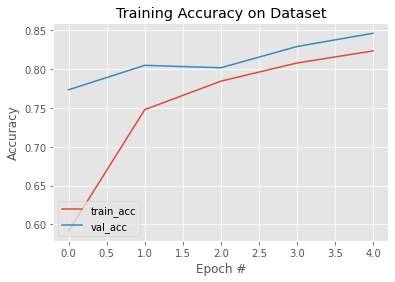

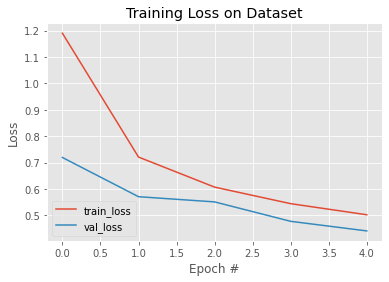

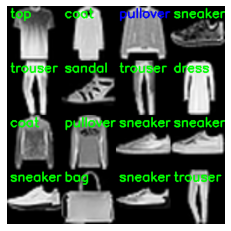

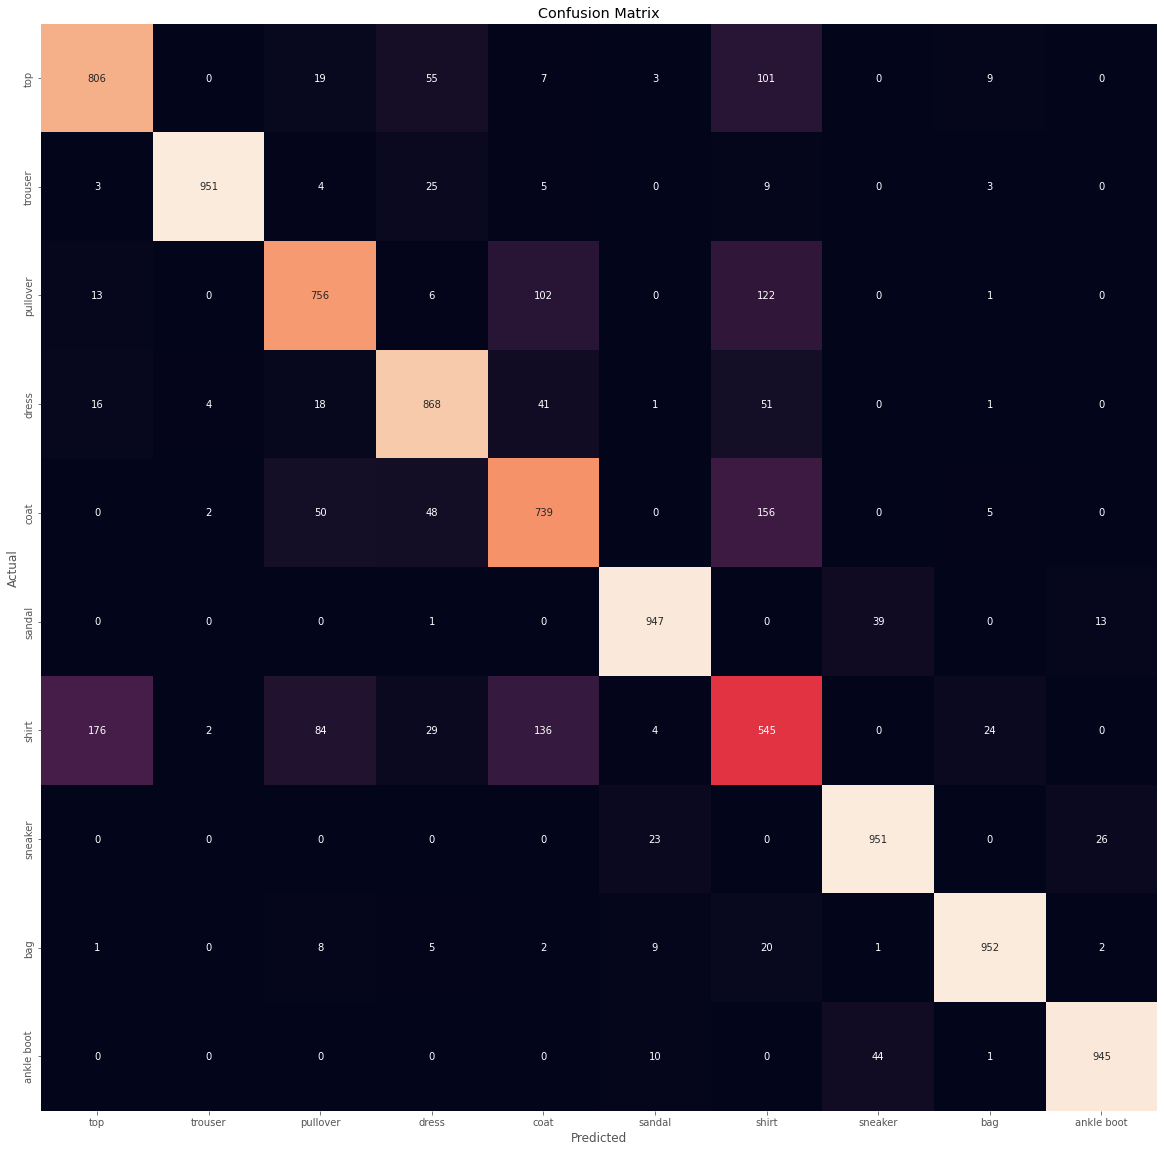

In [6]:
wrapper_f(fetcher       = fetch_and_resize_fashion_mnist,
          epochs        = 5,
          learning_rate = 1e-4,
          batch_size    = 32,
          augment       = "none")

[INFO] training model...
total seconds for training: 1054.134164
[INFO] testing model...
total seconds for testing: 9.072848
[INFO] evaluating network...
              precision    recall  f1-score   support

         top       0.84      0.85      0.85      1000
     trouser       0.99      0.97      0.98      1000
    pullover       0.81      0.91      0.86      1000
       dress       0.87      0.91      0.89      1000
        coat       0.78      0.91      0.84      1000
      sandal       0.99      0.94      0.97      1000
       shirt       0.81      0.56      0.67      1000
     sneaker       0.92      0.98      0.95      1000
         bag       0.99      0.97      0.98      1000
  ankle boot       0.97      0.96      0.96      1000

    accuracy                           0.90     10000
   macro avg       0.90      0.90      0.89     10000
weighted avg       0.90      0.90      0.89     10000



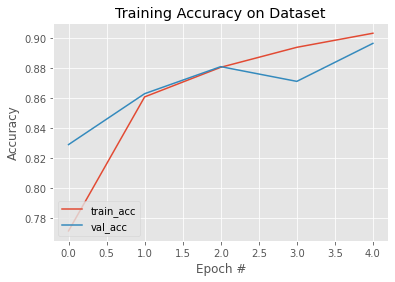

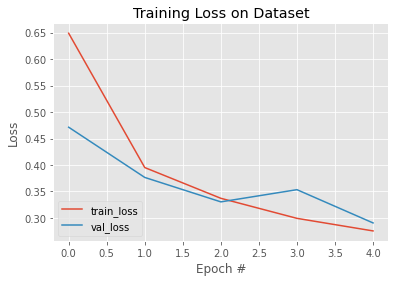

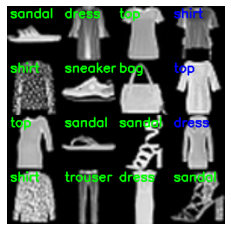

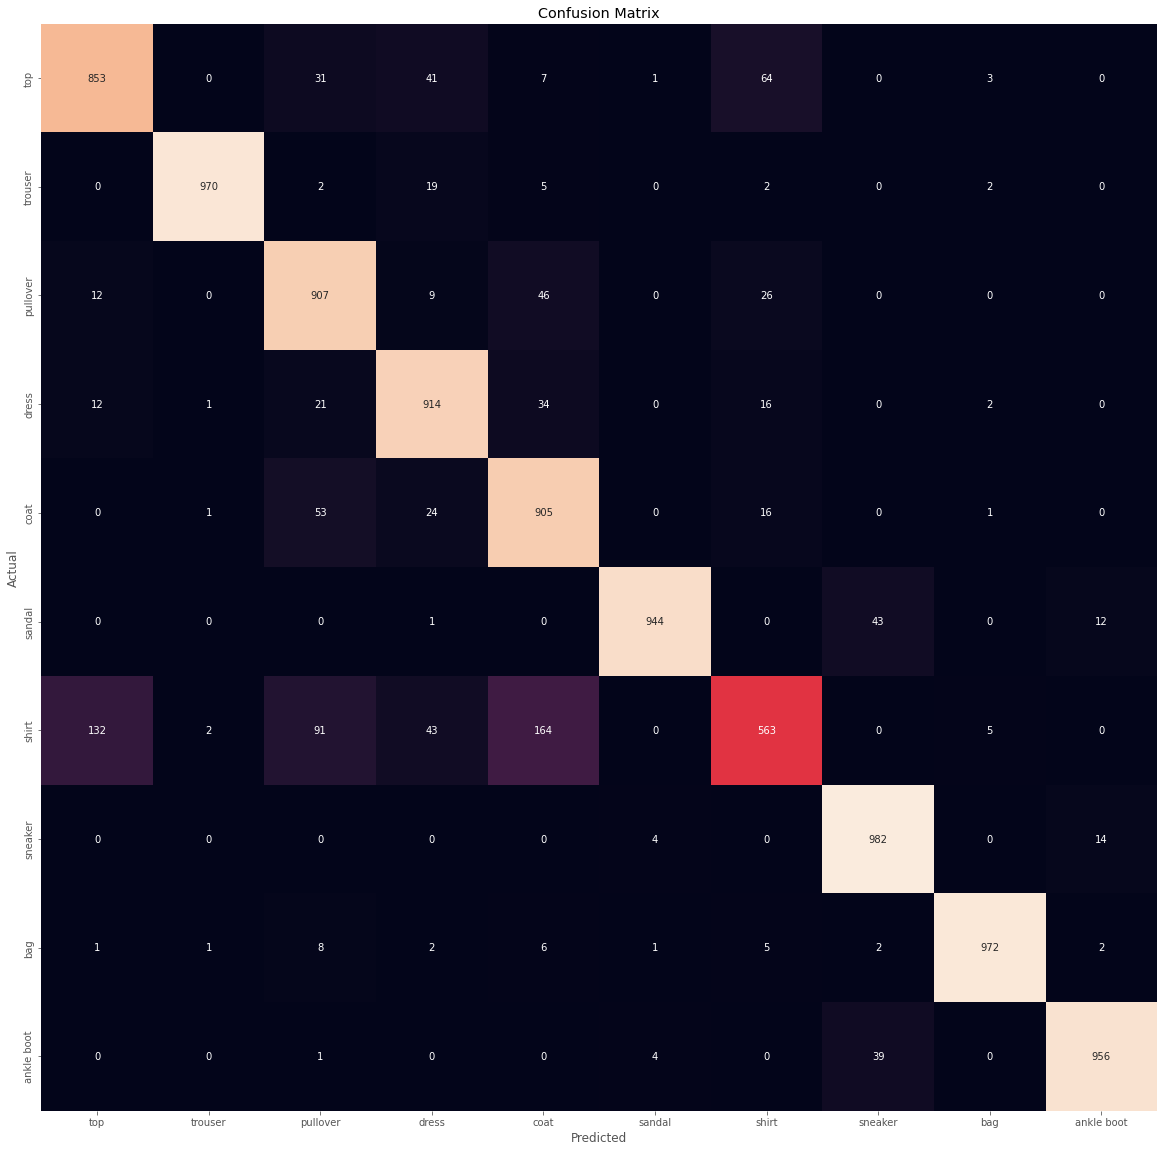

In [7]:
wrapper_f(fetcher       = fetch_and_resize_fashion_mnist,
          epochs        = 5,
          learning_rate = 1e-3,
          batch_size    = 32,
          augment       = "none")

[INFO] training model...
total seconds for training: 1054.119962
[INFO] testing model...
total seconds for testing: 9.024656
[INFO] evaluating network...
              precision    recall  f1-score   support

         top       0.85      0.89      0.87      1000
     trouser       0.99      0.98      0.99      1000
    pullover       0.88      0.89      0.89      1000
       dress       0.93      0.90      0.91      1000
        coat       0.84      0.91      0.87      1000
      sandal       0.99      0.98      0.98      1000
       shirt       0.79      0.72      0.75      1000
     sneaker       0.93      0.99      0.96      1000
         bag       0.99      0.99      0.99      1000
  ankle boot       0.99      0.94      0.97      1000

    accuracy                           0.92     10000
   macro avg       0.92      0.92      0.92     10000
weighted avg       0.92      0.92      0.92     10000



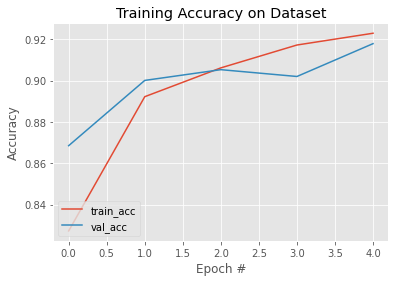

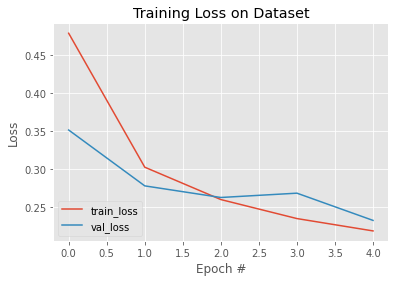

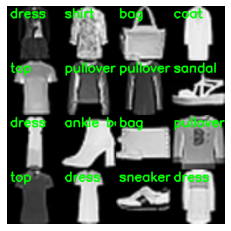

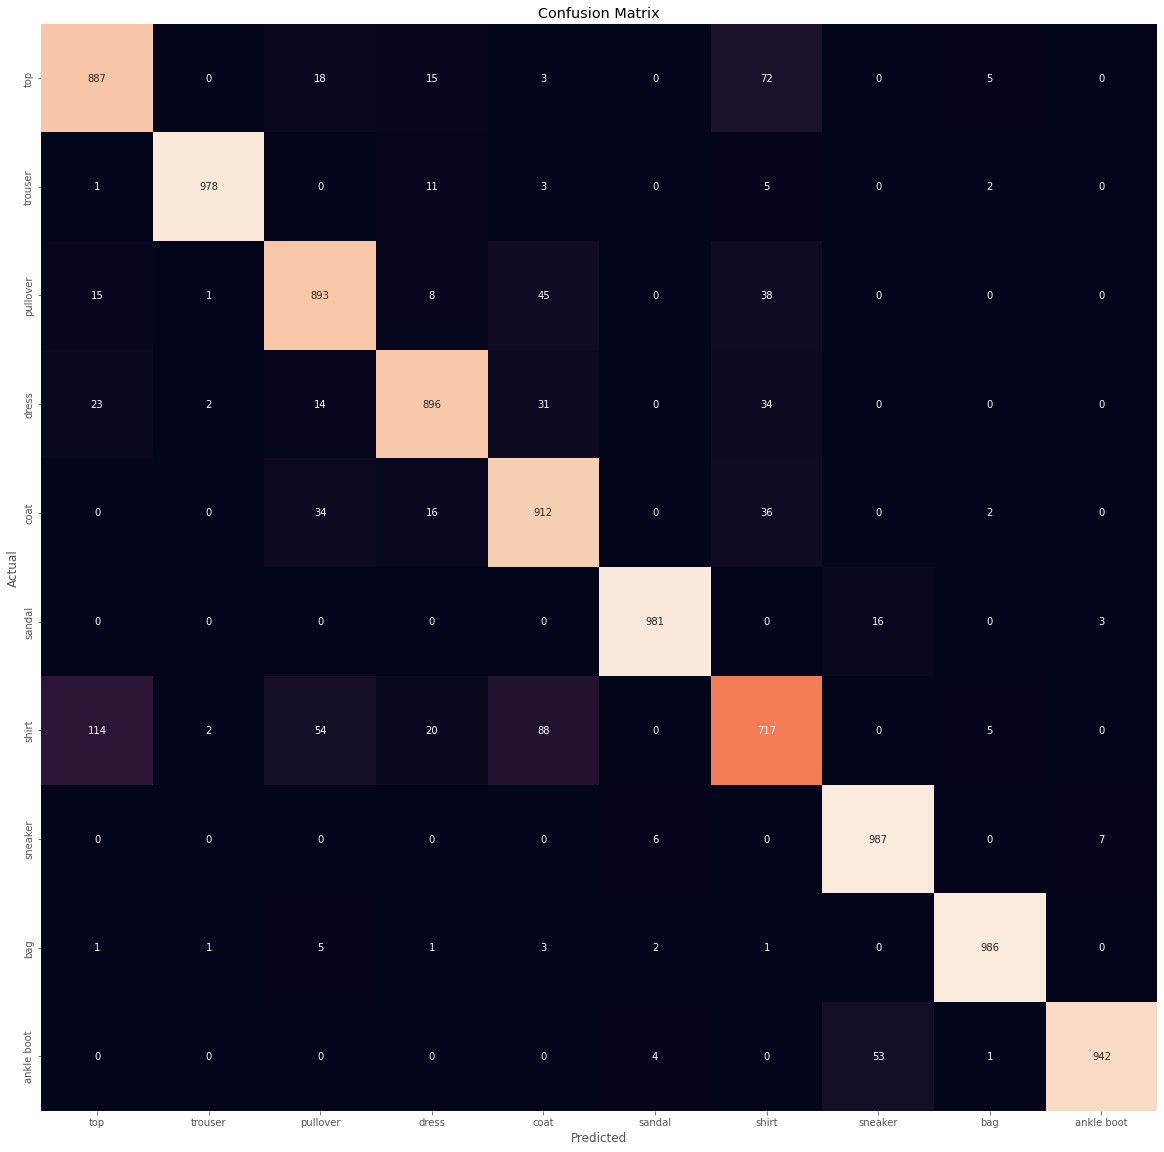

In [8]:
wrapper_f(fetcher       = fetch_and_resize_fashion_mnist,
          epochs        = 5,
          learning_rate = 1e-2,
          batch_size    = 32,
          augment       = "none")

[INFO] training model...
total seconds for training: 1052.398873
[INFO] testing model...
total seconds for testing: 9.076284
[INFO] evaluating network...
              precision    recall  f1-score   support

         top       0.85      0.81      0.83      1000
     trouser       1.00      0.97      0.98      1000
    pullover       0.88      0.80      0.84      1000
       dress       0.89      0.89      0.89      1000
        coat       0.72      0.92      0.81      1000
      sandal       0.99      0.96      0.98      1000
       shirt       0.74      0.64      0.69      1000
     sneaker       0.93      0.98      0.95      1000
         bag       0.97      0.97      0.97      1000
  ankle boot       0.97      0.95      0.96      1000

    accuracy                           0.89     10000
   macro avg       0.89      0.89      0.89     10000
weighted avg       0.89      0.89      0.89     10000



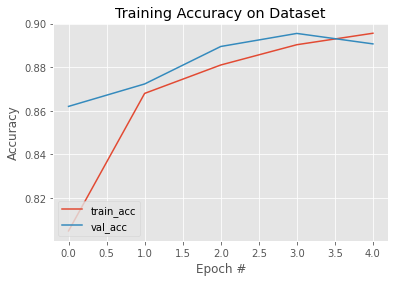

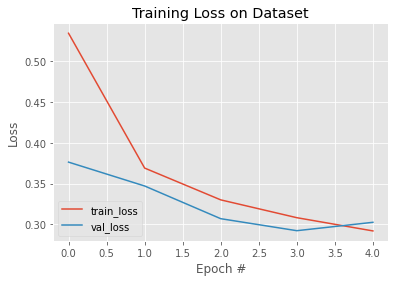

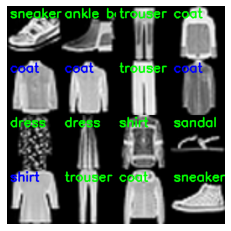

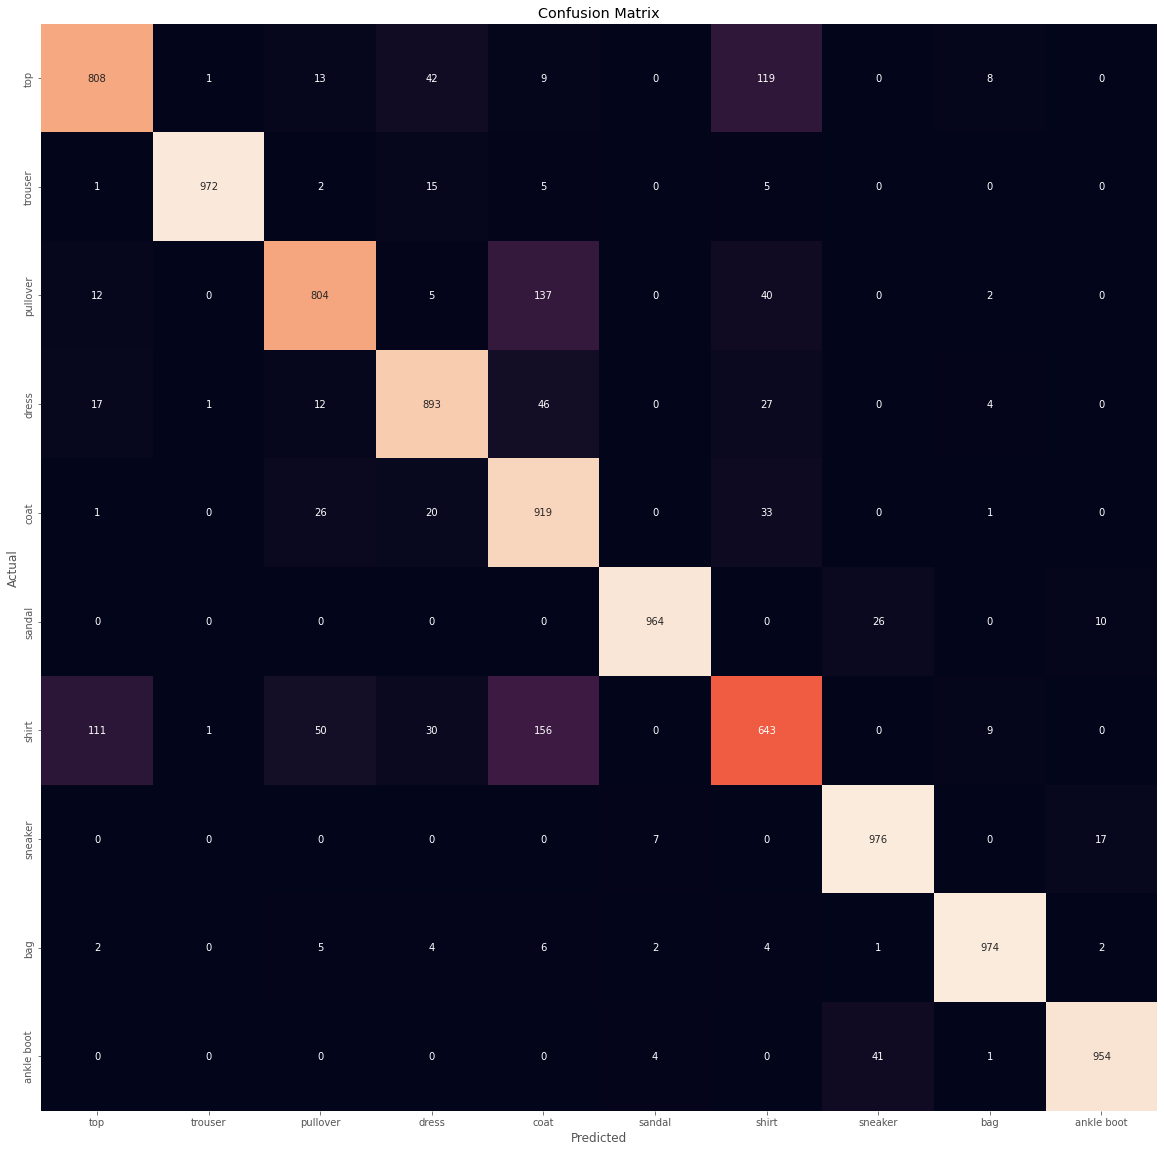

In [9]:
wrapper_f(fetcher       = fetch_and_resize_fashion_mnist,
          epochs        = 5,
          learning_rate = 1e-1,
          batch_size    = 32,
          augment       = "none")

The best performance was found with a learning rate of 1e-2 and was 0.92 for all the metrics.

### Fashion MNIST with augmentation (selection)

We are going for the "reduced" augment setting here. If you look at the examples of how the MNIST dataset looks like, the clothing is very much laid out in a standardized way.
We decided to skip the horizontal and vertical shifts as well as the zoom that was used in Thomas Lidy's notebook and limited ourselves to horizontal flips and rotations.

[INFO] training model...
total seconds for training: 1052.376598
[INFO] testing model...
total seconds for testing: 9.090494
[INFO] evaluating network...
              precision    recall  f1-score   support

         top       0.83      0.74      0.79      1000
     trouser       0.99      0.94      0.97      1000
    pullover       0.79      0.65      0.71      1000
       dress       0.75      0.88      0.81      1000
        coat       0.63      0.75      0.69      1000
      sandal       0.93      0.92      0.93      1000
       shirt       0.51      0.49      0.50      1000
     sneaker       0.87      0.94      0.90      1000
         bag       0.95      0.94      0.94      1000
  ankle boot       0.95      0.91      0.93      1000

    accuracy                           0.82     10000
   macro avg       0.82      0.82      0.82     10000
weighted avg       0.82      0.82      0.82     10000



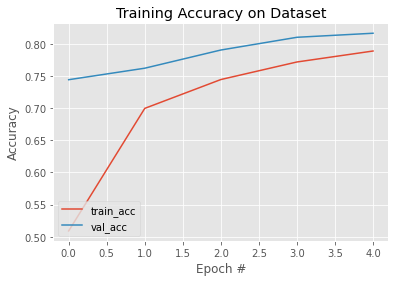

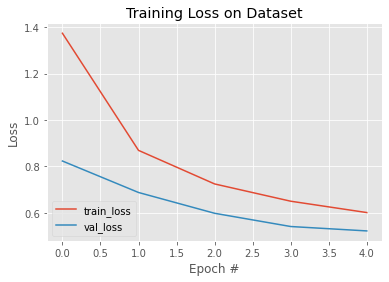

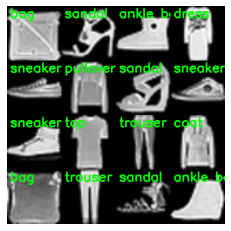

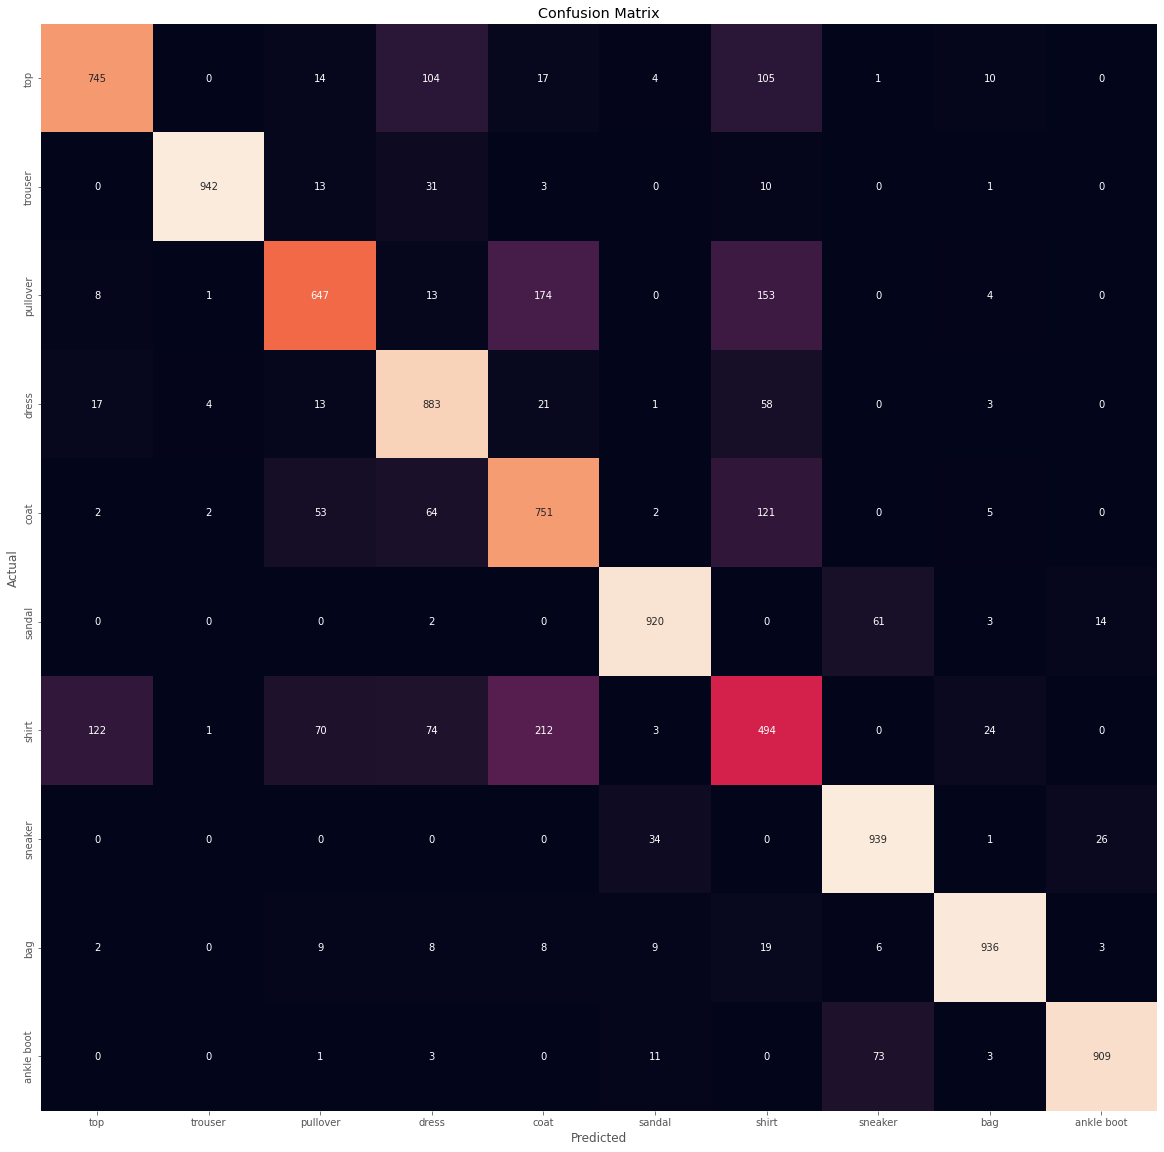

In [10]:
wrapper_f(fetcher       = fetch_and_resize_fashion_mnist,
          epochs        = 5,
          learning_rate = 1e-4,
          batch_size    = 32,
          augment       = "reduced")

[INFO] training model...
total seconds for training: 1051.608004
[INFO] testing model...
total seconds for testing: 9.003782
[INFO] evaluating network...
              precision    recall  f1-score   support

         top       0.89      0.67      0.76      1000
     trouser       0.97      0.98      0.97      1000
    pullover       0.91      0.62      0.74      1000
       dress       0.90      0.83      0.86      1000
        coat       0.63      0.94      0.75      1000
      sandal       0.97      0.94      0.95      1000
       shirt       0.57      0.66      0.61      1000
     sneaker       0.85      0.98      0.91      1000
         bag       0.98      0.96      0.97      1000
  ankle boot       0.98      0.88      0.93      1000

    accuracy                           0.84     10000
   macro avg       0.87      0.84      0.85     10000
weighted avg       0.87      0.84      0.85     10000



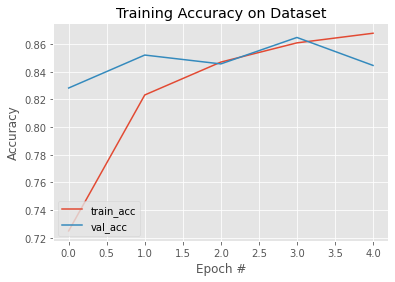

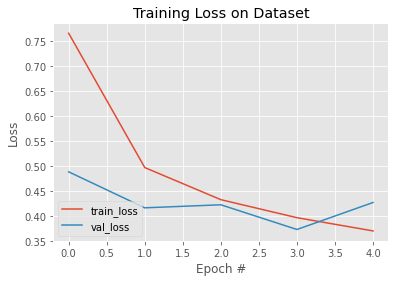

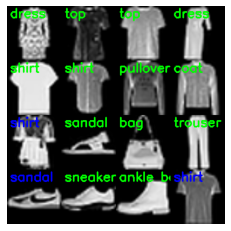

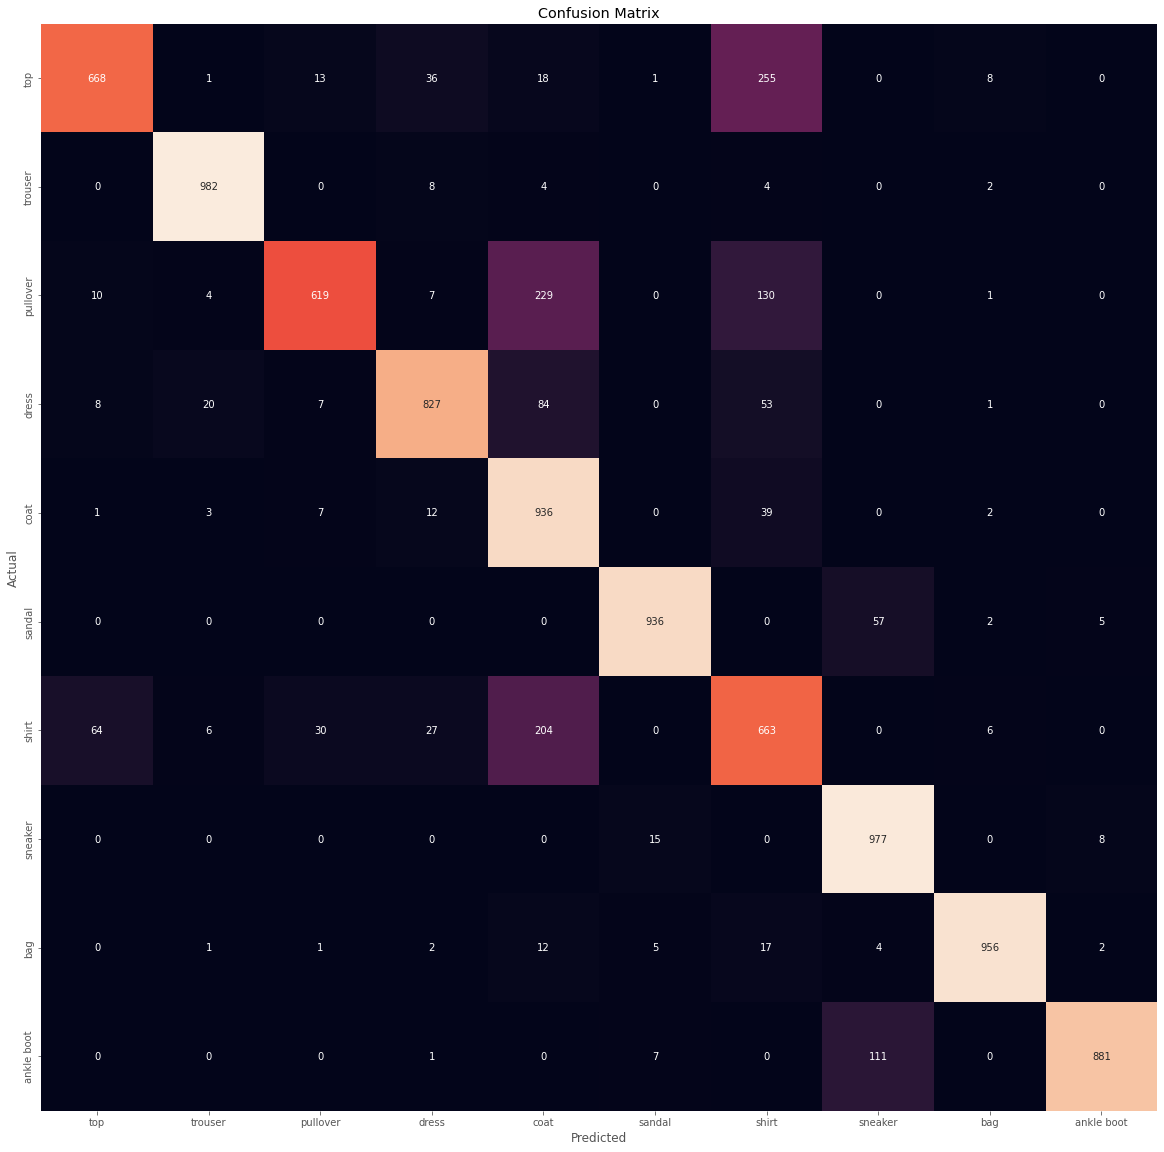

In [11]:
wrapper_f(fetcher       = fetch_and_resize_fashion_mnist,
          epochs        = 5,
          learning_rate = 1e-3,
          batch_size    = 32,
          augment       = "reduced")

[INFO] training model...
total seconds for training: 1057.271161
[INFO] testing model...
total seconds for testing: 8.989577
[INFO] evaluating network...
              precision    recall  f1-score   support

         top       0.86      0.84      0.85      1000
     trouser       1.00      0.97      0.98      1000
    pullover       0.90      0.84      0.87      1000
       dress       0.86      0.92      0.89      1000
        coat       0.85      0.83      0.84      1000
      sandal       0.93      0.99      0.96      1000
       shirt       0.69      0.73      0.71      1000
     sneaker       0.95      0.91      0.93      1000
         bag       0.97      0.98      0.98      1000
  ankle boot       0.96      0.95      0.95      1000

    accuracy                           0.90     10000
   macro avg       0.90      0.90      0.90     10000
weighted avg       0.90      0.90      0.90     10000



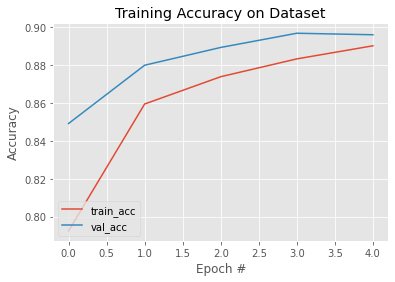

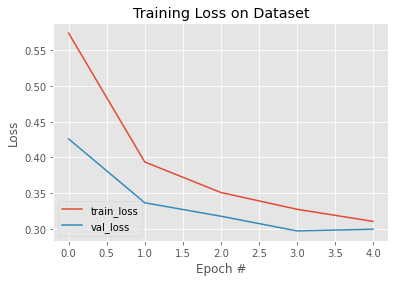

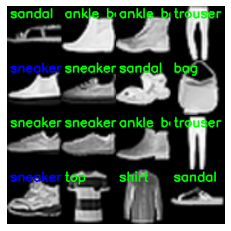

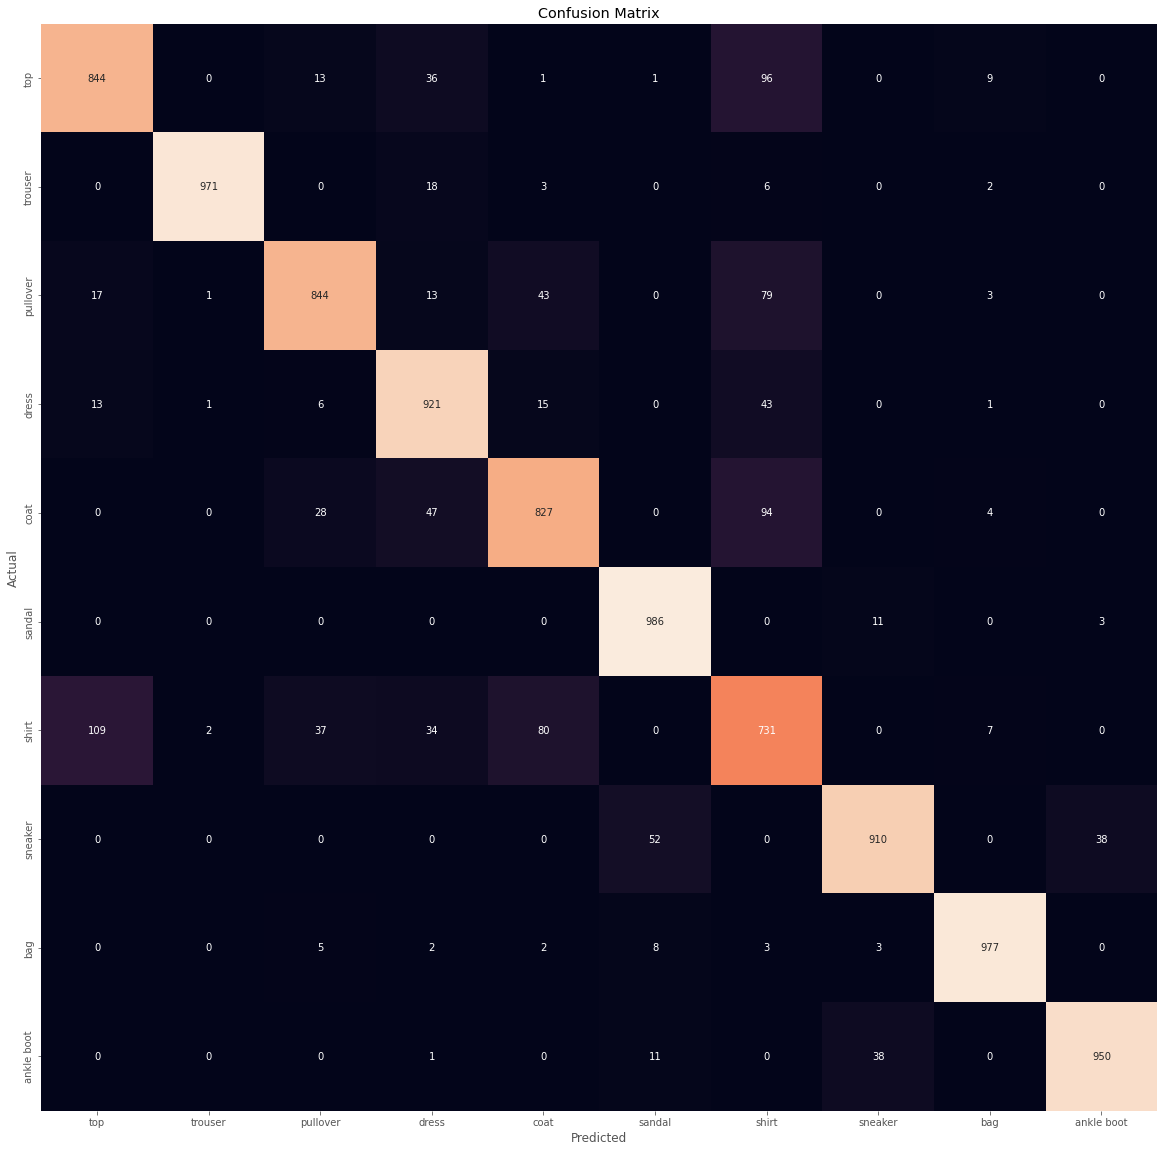

In [12]:
wrapper_f(fetcher       = fetch_and_resize_fashion_mnist,
          epochs        = 5,
          learning_rate = 1e-2,
          batch_size    = 32,
          augment       = "reduced")

[INFO] training model...
total seconds for training: 1106.346959
[INFO] testing model...
total seconds for testing: 9.008214
[INFO] evaluating network...
              precision    recall  f1-score   support

         top       0.84      0.81      0.83      1000
     trouser       0.99      0.97      0.98      1000
    pullover       0.87      0.78      0.82      1000
       dress       0.87      0.87      0.87      1000
        coat       0.78      0.83      0.80      1000
      sandal       0.94      0.97      0.96      1000
       shirt       0.62      0.67      0.64      1000
     sneaker       0.91      0.94      0.92      1000
         bag       0.97      0.97      0.97      1000
  ankle boot       0.96      0.93      0.95      1000

    accuracy                           0.87     10000
   macro avg       0.88      0.87      0.87     10000
weighted avg       0.88      0.87      0.87     10000



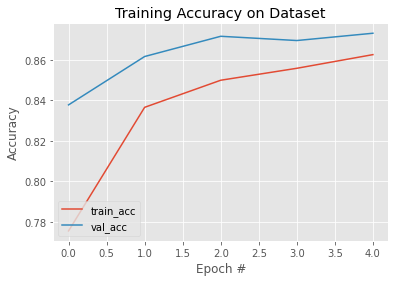

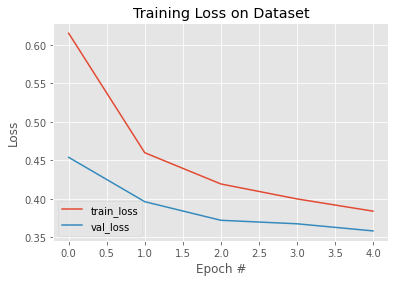

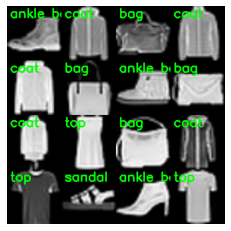

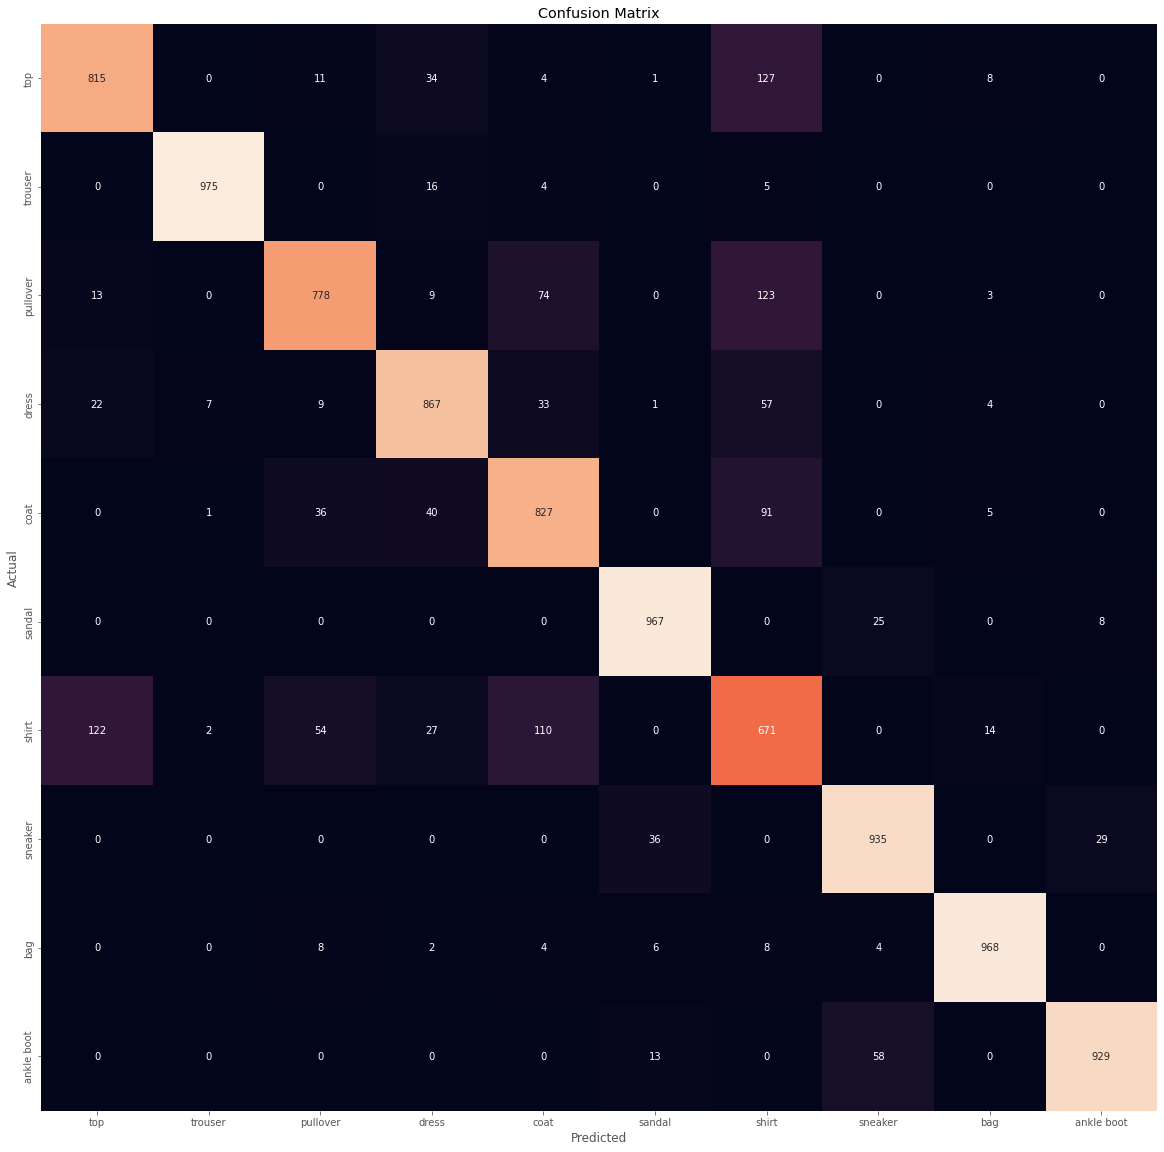

In [13]:
wrapper_f(fetcher       = fetch_and_resize_fashion_mnist,
          epochs        = 5,
          learning_rate = 1e-1,
          batch_size    = 32,
          augment       = "reduced")

The best performance from the above was with the learning rate 1e-2, with all scores performing at 0.90

### LFW dataset without augmentation

For the LFW dataset, 75 epochs take roughly quarter an hour to train.

[INFO] training model...
total seconds for training: 952.656437
[INFO] testing model...
total seconds for testing: 1.643918
[INFO] evaluating network...
                           precision    recall  f1-score   support

         Alejandro Toledo       0.44      0.54      0.48        13
             Alvaro Uribe       0.00      0.00      0.00        12
          Amelie Mauresmo       0.00      0.00      0.00        10
             Andre Agassi       1.00      0.14      0.25        14
           Angelina Jolie       0.00      0.00      0.00         9
             Ariel Sharon       0.31      0.88      0.46        25
    Arnold Schwarzenegger       0.00      0.00      0.00        22
     Atal Bihari Vajpayee       0.00      0.00      0.00         9
             Bill Clinton       0.00      0.00      0.00        11
             Carlos Menem       0.00      0.00      0.00         5
             Colin Powell       0.33      0.93      0.49        87
            David Beckham       0.00      

/home/debian/ipynb/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/debian/ipynb/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/debian/ipynb/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


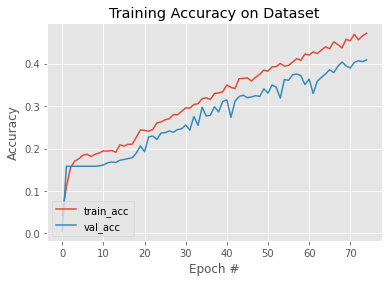

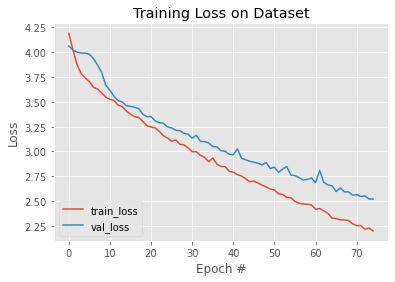

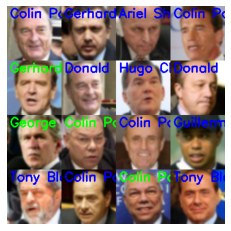

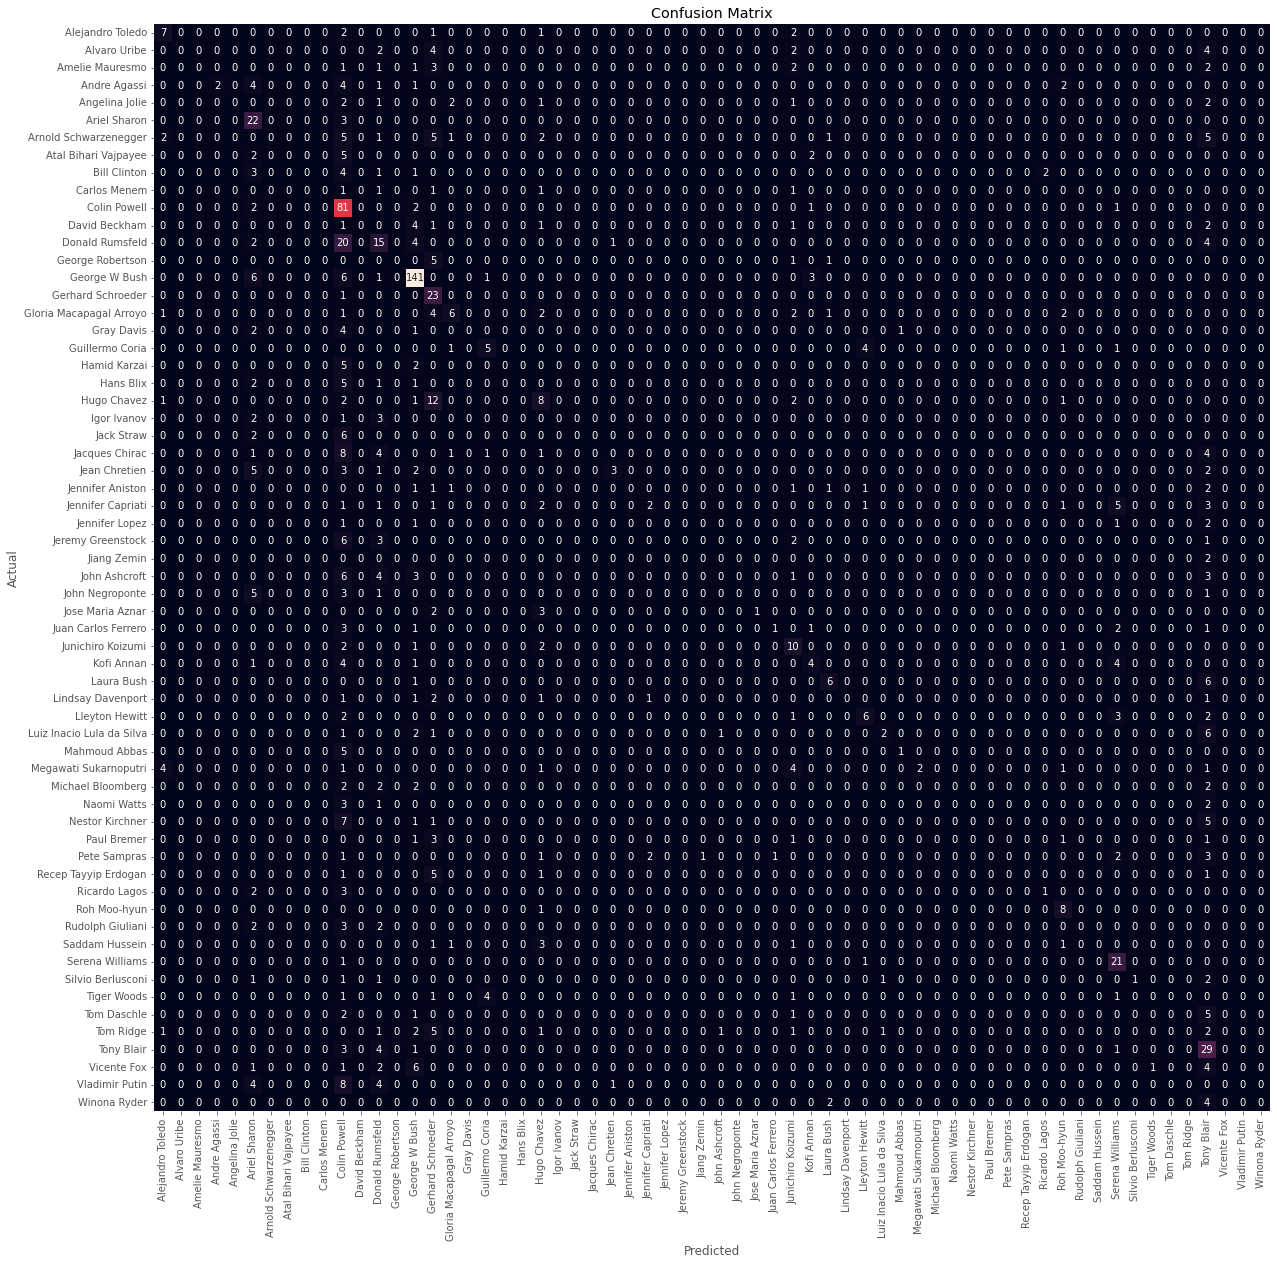

In [14]:
wrapper_f(fetcher       = fetch_lfw,
          epochs        = 75,
          learning_rate = 1e-4,
          batch_size    = 32,
          augment       = False)

[INFO] training model...
total seconds for training: 887.686211
[INFO] testing model...
total seconds for testing: 1.655264
[INFO] evaluating network...
                           precision    recall  f1-score   support

         Alejandro Toledo       0.69      0.85      0.76        13
             Alvaro Uribe       0.78      0.58      0.67        12
          Amelie Mauresmo       0.67      0.20      0.31        10
             Andre Agassi       1.00      0.64      0.78        14
           Angelina Jolie       0.50      0.56      0.53         9
             Ariel Sharon       0.73      0.88      0.80        25
    Arnold Schwarzenegger       1.00      0.27      0.43        22
     Atal Bihari Vajpayee       0.29      0.56      0.38         9
             Bill Clinton       0.80      0.73      0.76        11
             Carlos Menem       0.50      0.60      0.55         5
             Colin Powell       1.00      0.77      0.87        87
            David Beckham       0.00      

/home/debian/ipynb/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/debian/ipynb/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/debian/ipynb/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


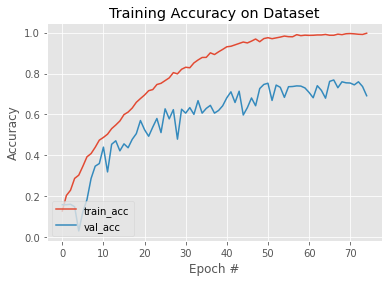

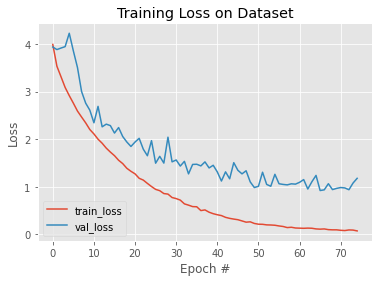

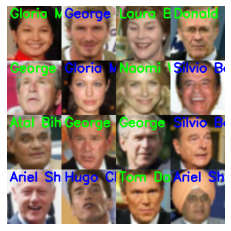

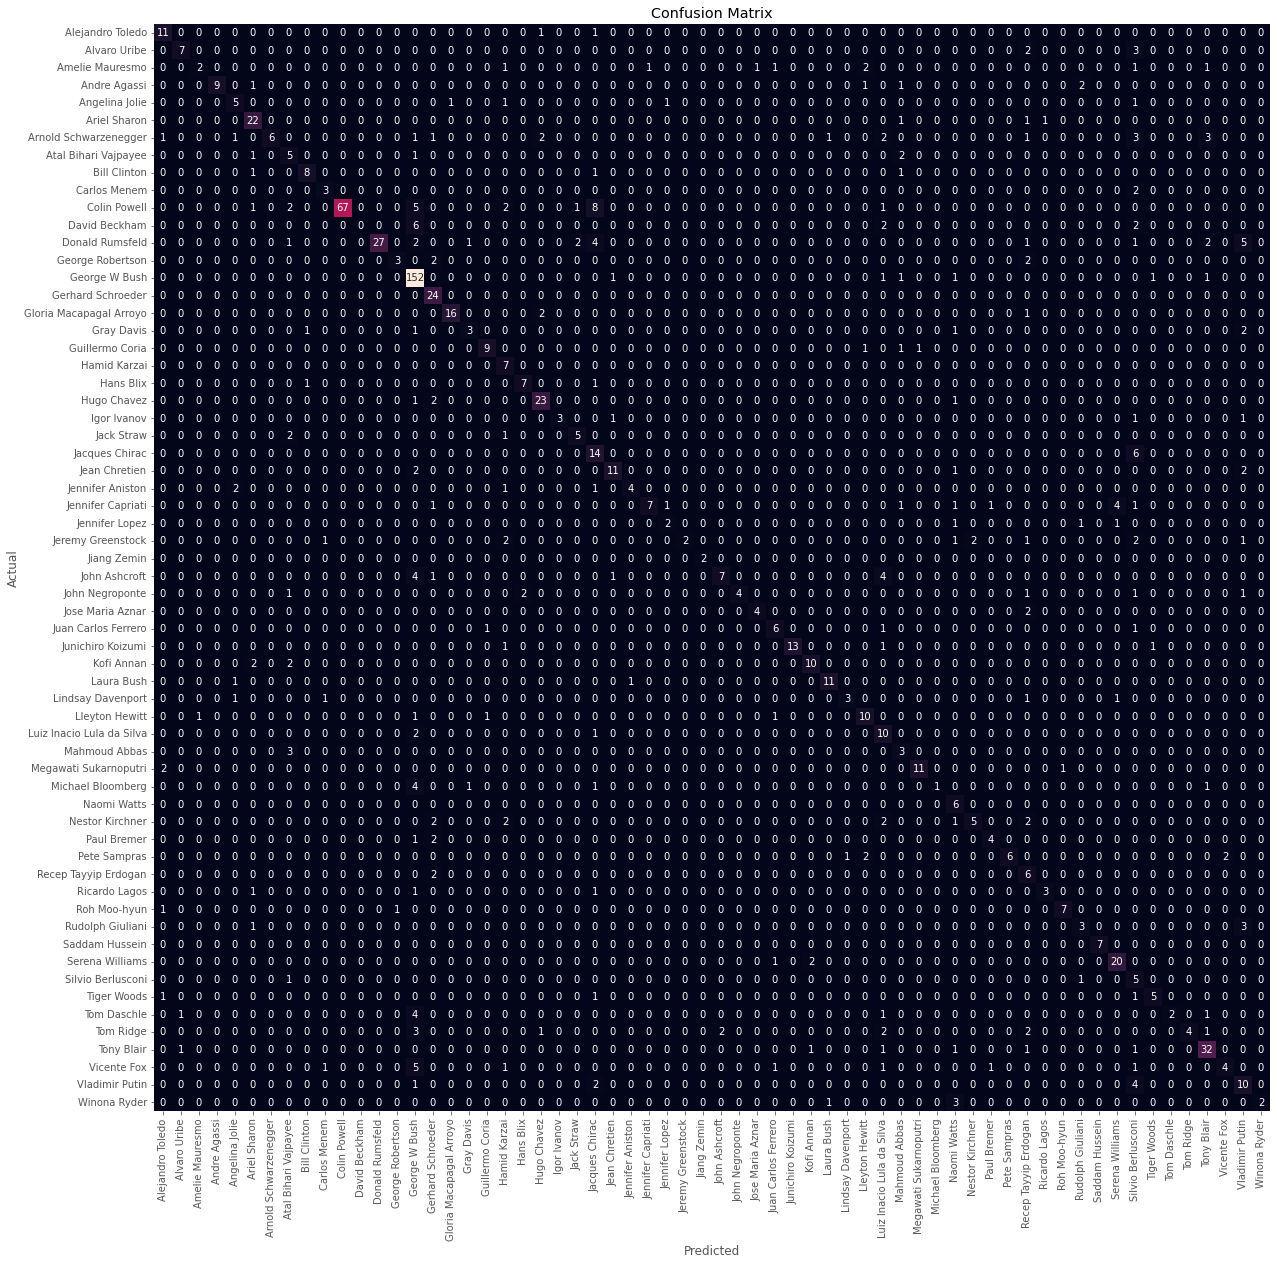

In [15]:
wrapper_f(fetcher       = fetch_lfw,
          epochs        = 75,
          learning_rate = 1e-3,
          batch_size    = 32,
          augment       = False)

[INFO] training model...
total seconds for training: 883.976005
[INFO] testing model...
total seconds for testing: 1.666257
[INFO] evaluating network...
                           precision    recall  f1-score   support

         Alejandro Toledo       0.90      0.69      0.78        13
             Alvaro Uribe       0.80      1.00      0.89        12
          Amelie Mauresmo       0.86      0.60      0.71        10
             Andre Agassi       1.00      0.64      0.78        14
           Angelina Jolie       0.86      0.67      0.75         9
             Ariel Sharon       0.74      0.92      0.82        25
    Arnold Schwarzenegger       1.00      0.55      0.71        22
     Atal Bihari Vajpayee       0.70      0.78      0.74         9
             Bill Clinton       0.85      1.00      0.92        11
             Carlos Menem       1.00      1.00      1.00         5
             Colin Powell       0.99      0.94      0.96        87
            David Beckham       0.67      

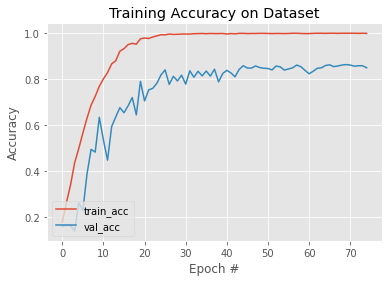

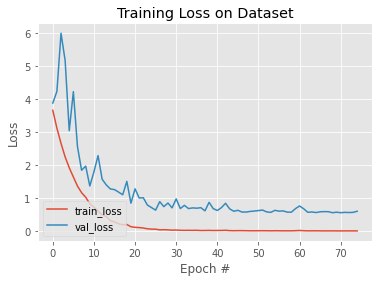

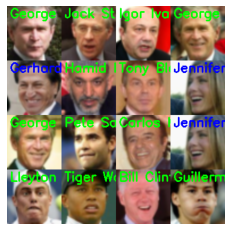

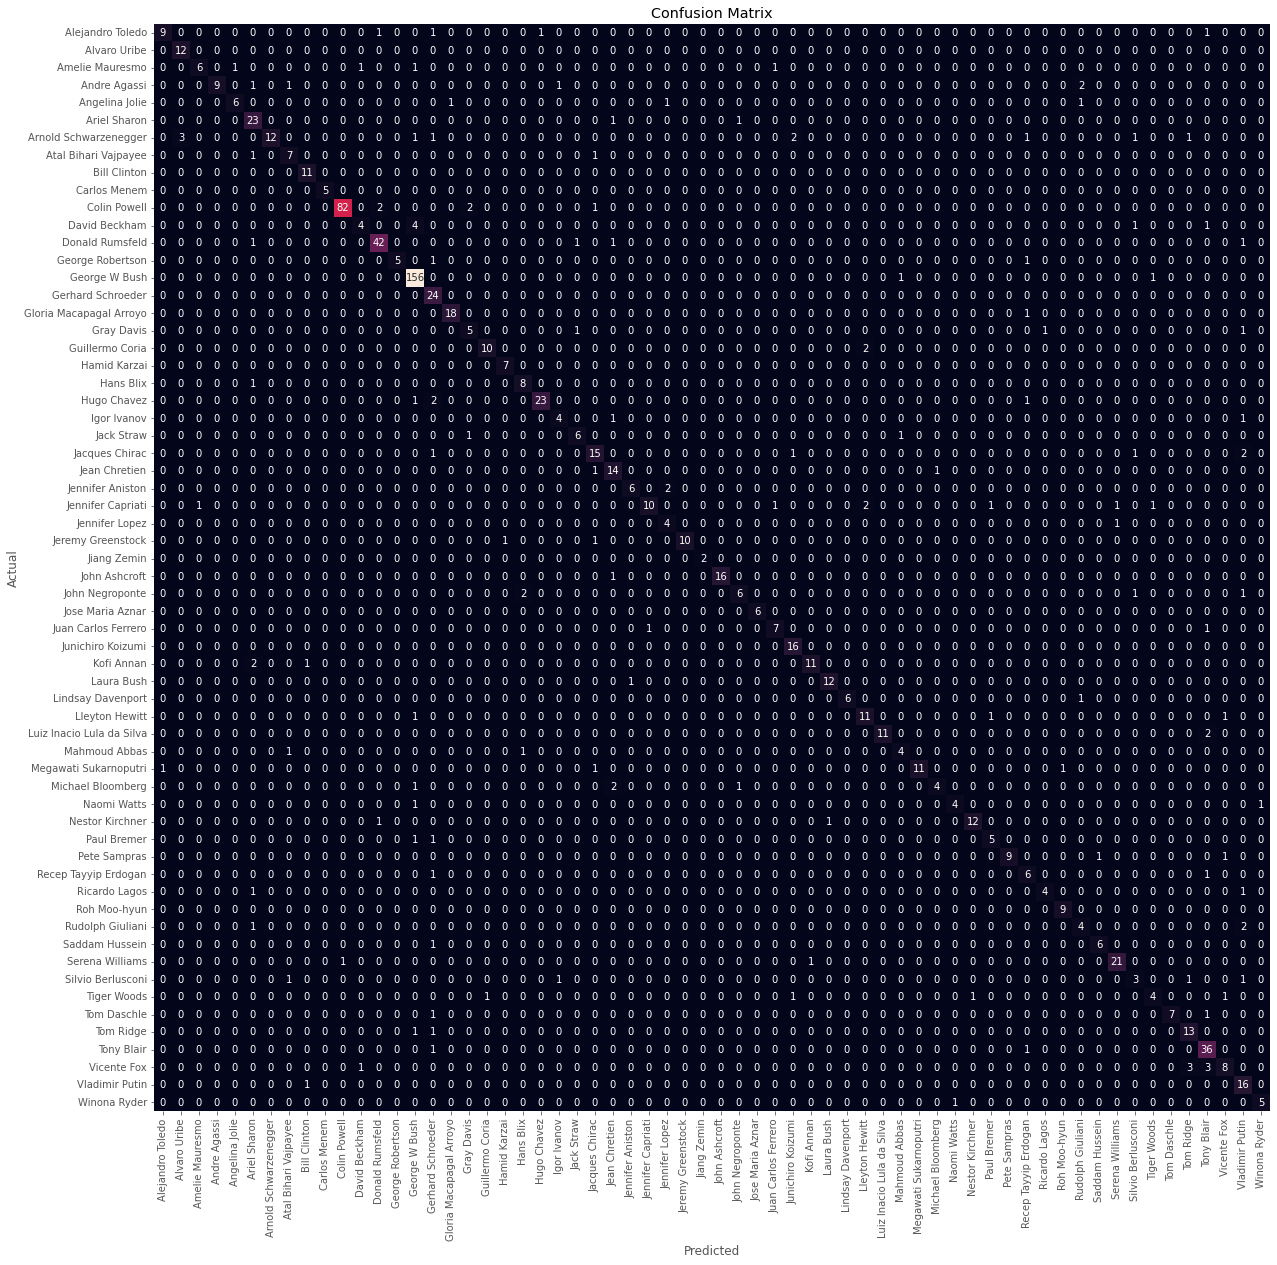

In [16]:
wrapper_f(fetcher       = fetch_lfw,
          epochs        = 75,
          learning_rate = 1e-2,
          batch_size    = 32,
          augment       = False)

[INFO] training model...
total seconds for training: 885.418755
[INFO] testing model...
total seconds for testing: 1.64076
[INFO] evaluating network...
                           precision    recall  f1-score   support

         Alejandro Toledo       0.75      0.92      0.83        13
             Alvaro Uribe       0.85      0.92      0.88        12
          Amelie Mauresmo       1.00      0.50      0.67        10
             Andre Agassi       1.00      0.79      0.88        14
           Angelina Jolie       1.00      0.78      0.88         9
             Ariel Sharon       0.83      0.96      0.89        25
    Arnold Schwarzenegger       0.93      0.59      0.72        22
     Atal Bihari Vajpayee       0.75      0.67      0.71         9
             Bill Clinton       1.00      0.82      0.90        11
             Carlos Menem       0.83      1.00      0.91         5
             Colin Powell       0.96      0.94      0.95        87
            David Beckham       0.40      0

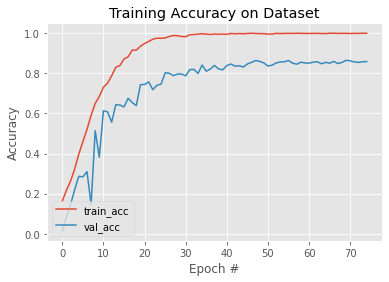

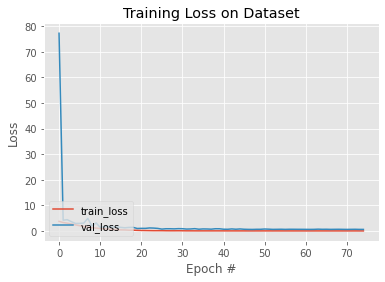

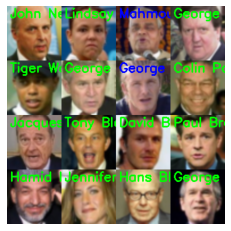

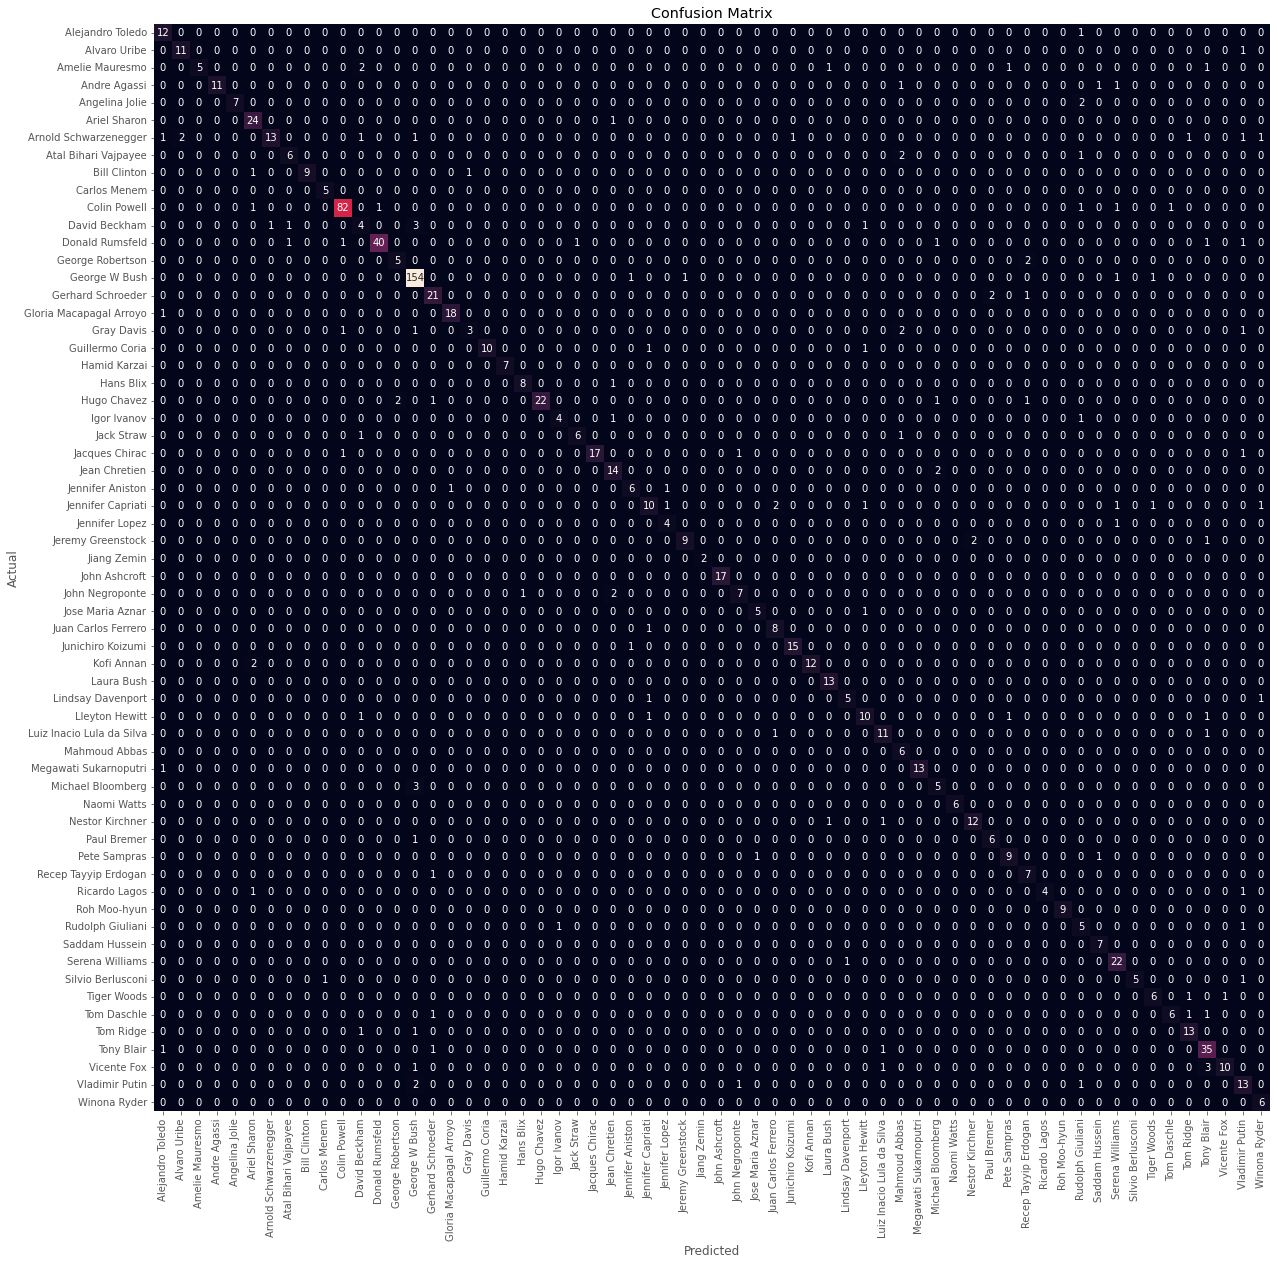

In [17]:
wrapper_f(fetcher       = fetch_lfw,
          epochs        = 75,
          learning_rate = 1e-1,
          batch_size    = 32,
          augment       = False)

The best performance was reached with a learning rate of 1e-1.

### LFW dataset with augmentation

This given dataset is less standardized than the MNIST dataset. Faces can look to the size more, be more rotated or not fully captured. Thus, we used the same toolset that Thomas Lidy used in his notebook: rotation, horizontal and vertical shifts, zooming and horizontal flipping.

[INFO] training model...
total seconds for training: 887.618227
[INFO] testing model...
total seconds for testing: 1.640509
[INFO] evaluating network...
                           precision    recall  f1-score   support

         Alejandro Toledo       0.00      0.00      0.00        13
             Alvaro Uribe       0.00      0.00      0.00        12
          Amelie Mauresmo       0.00      0.00      0.00        10
             Andre Agassi       0.00      0.00      0.00        14
           Angelina Jolie       0.00      0.00      0.00         9
             Ariel Sharon       1.00      0.12      0.21        25
    Arnold Schwarzenegger       0.00      0.00      0.00        22
     Atal Bihari Vajpayee       0.00      0.00      0.00         9
             Bill Clinton       0.00      0.00      0.00        11
             Carlos Menem       0.00      0.00      0.00         5
             Colin Powell       0.31      0.38      0.34        87
            David Beckham       0.00      

/home/debian/ipynb/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/debian/ipynb/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/debian/ipynb/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


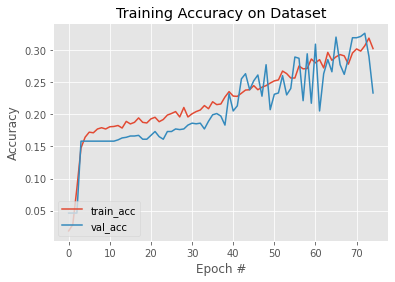

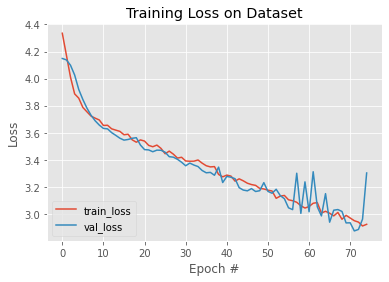

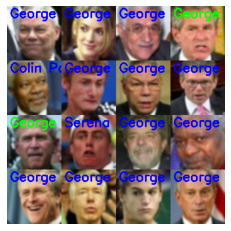

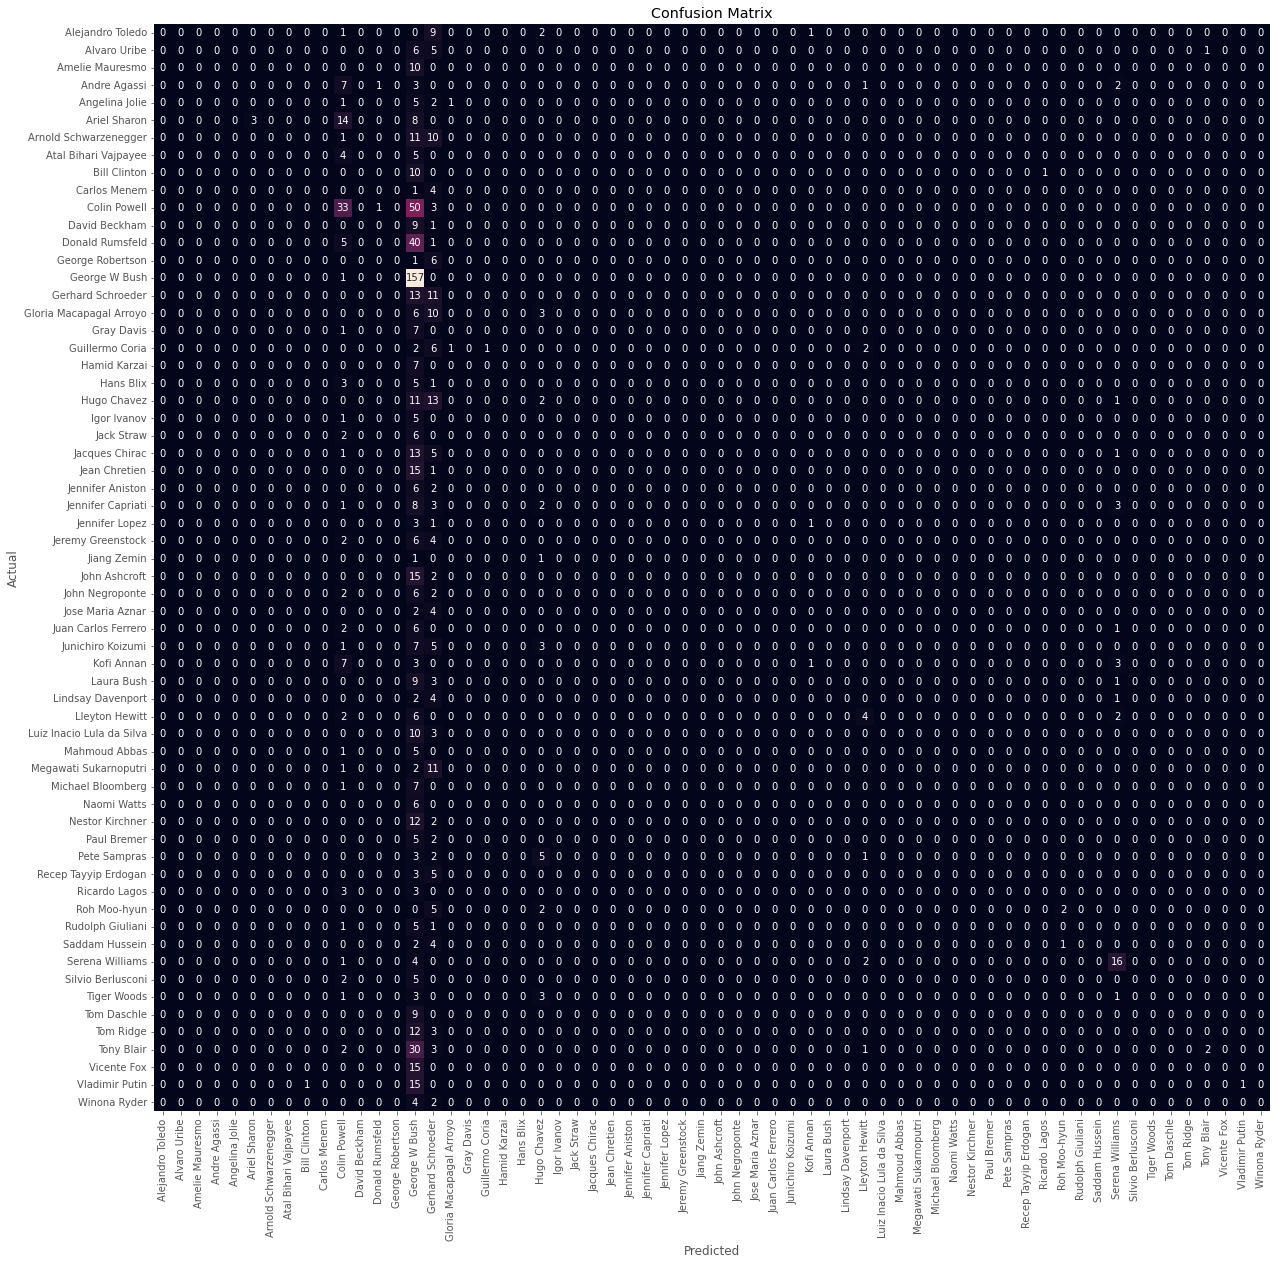

In [18]:
wrapper_f(fetcher       = fetch_lfw,
          epochs        = 75,
          learning_rate = 1e-4,
          batch_size    = 32,
          augment       = "full")

[INFO] training model...
total seconds for training: 887.32279
[INFO] testing model...
total seconds for testing: 1.669076
[INFO] evaluating network...
                           precision    recall  f1-score   support

         Alejandro Toledo       0.50      0.77      0.61        13
             Alvaro Uribe       0.56      0.75      0.64        12
          Amelie Mauresmo       1.00      0.10      0.18        10
             Andre Agassi       0.34      0.79      0.48        14
           Angelina Jolie       0.00      0.00      0.00         9
             Ariel Sharon       0.41      1.00      0.58        25
    Arnold Schwarzenegger       0.44      0.68      0.54        22
     Atal Bihari Vajpayee       0.47      0.78      0.58         9
             Bill Clinton       0.89      0.73      0.80        11
             Carlos Menem       0.50      0.60      0.55         5
             Colin Powell       1.00      0.74      0.85        87
            David Beckham       0.00      0

/home/debian/ipynb/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/debian/ipynb/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/debian/ipynb/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


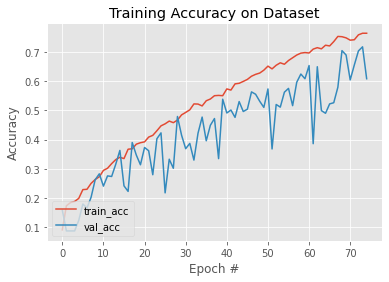

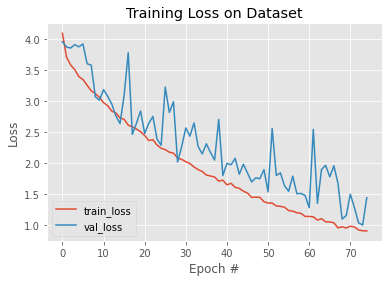

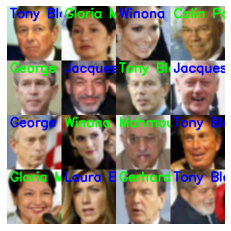

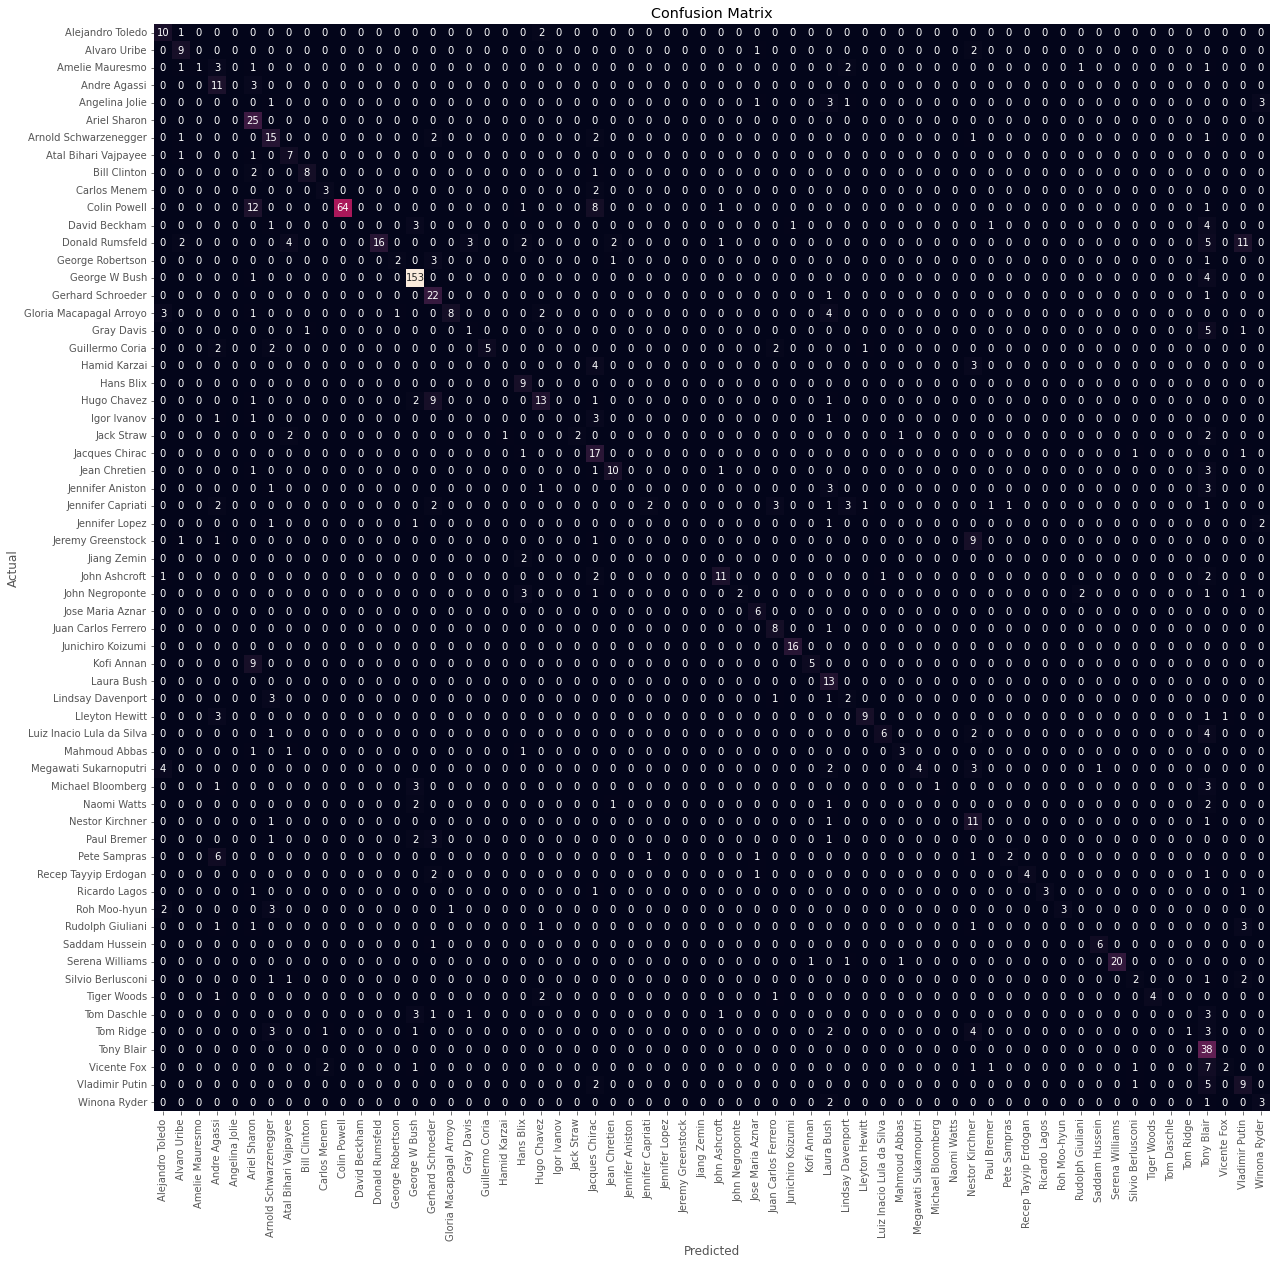

In [19]:
wrapper_f(fetcher       = fetch_lfw,
          epochs        = 75,
          learning_rate = 1e-3,
          batch_size    = 32,
          augment       = "full")

[INFO] training model...
total seconds for training: 887.21522
[INFO] testing model...
total seconds for testing: 1.643547
[INFO] evaluating network...
                           precision    recall  f1-score   support

         Alejandro Toledo       0.69      0.69      0.69        13
             Alvaro Uribe       0.92      0.92      0.92        12
          Amelie Mauresmo       0.42      0.50      0.45        10
             Andre Agassi       0.92      0.86      0.89        14
           Angelina Jolie       1.00      0.44      0.62         9
             Ariel Sharon       1.00      0.92      0.96        25
    Arnold Schwarzenegger       1.00      0.59      0.74        22
     Atal Bihari Vajpayee       1.00      0.56      0.71         9
             Bill Clinton       0.92      1.00      0.96        11
             Carlos Menem       1.00      0.60      0.75         5
             Colin Powell       0.90      0.99      0.94        87
            David Beckham       0.83      0

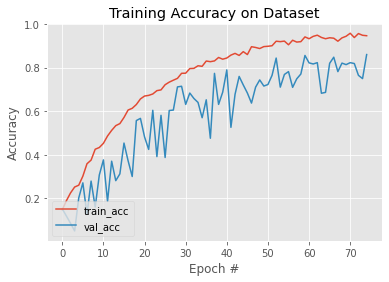

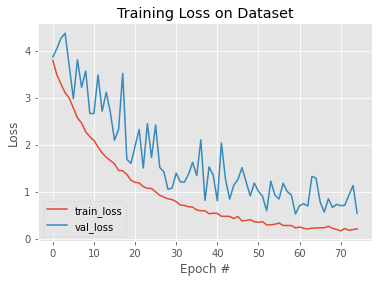

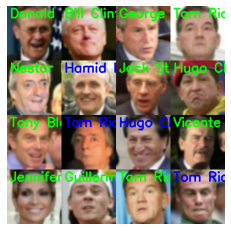

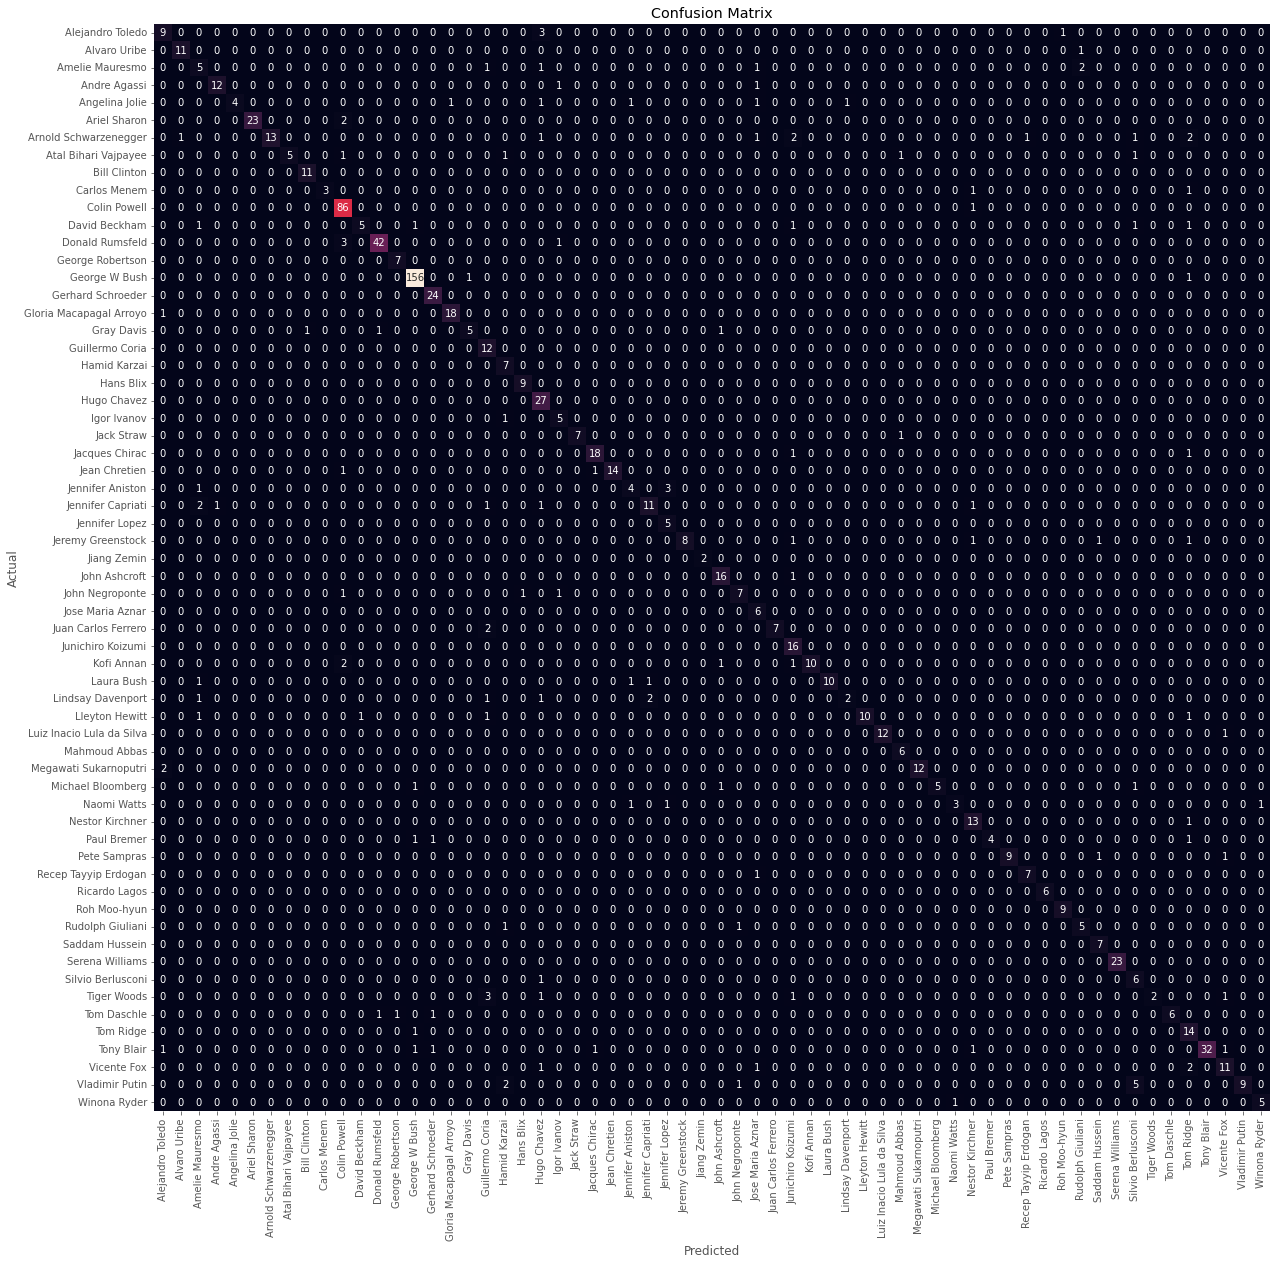

In [20]:
wrapper_f(fetcher       = fetch_lfw,
          epochs        = 75,
          learning_rate = 1e-2,
          batch_size    = 32,
          augment       = "full")

[INFO] training model...
total seconds for training: 907.51905
[INFO] testing model...
total seconds for testing: 1.695401
[INFO] evaluating network...
                           precision    recall  f1-score   support

         Alejandro Toledo       0.71      0.92      0.80        13
             Alvaro Uribe       0.85      0.92      0.88        12
          Amelie Mauresmo       0.67      0.60      0.63        10
             Andre Agassi       1.00      0.79      0.88        14
           Angelina Jolie       1.00      0.22      0.36         9
             Ariel Sharon       1.00      0.88      0.94        25
    Arnold Schwarzenegger       0.92      0.55      0.69        22
     Atal Bihari Vajpayee       1.00      0.44      0.62         9
             Bill Clinton       1.00      1.00      1.00        11
             Carlos Menem       0.80      0.80      0.80         5
             Colin Powell       0.91      0.99      0.95        87
            David Beckham       0.57      0

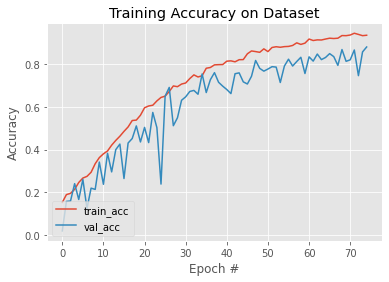

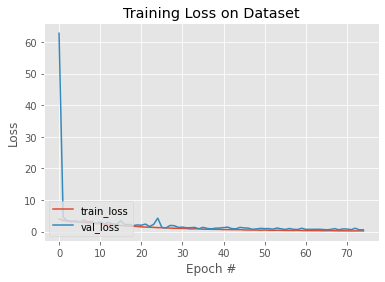

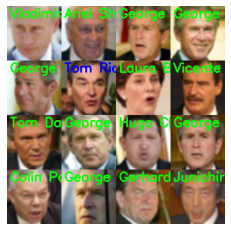

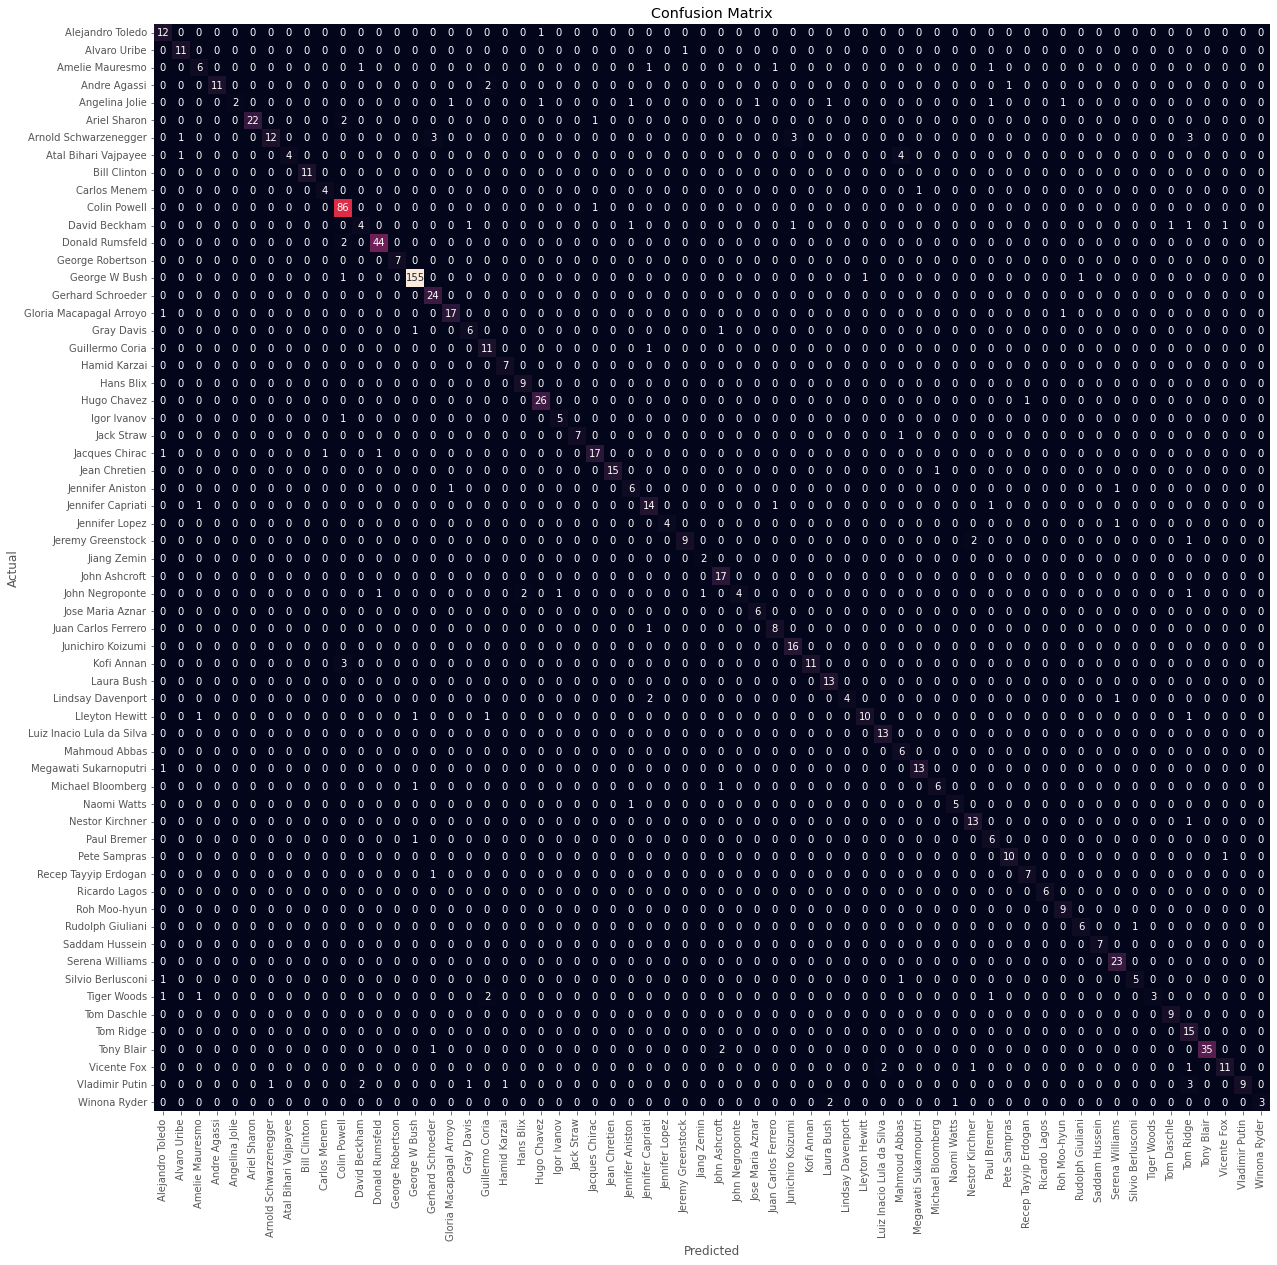

In [21]:
wrapper_f(fetcher       = fetch_lfw,
          epochs        = 75,
          learning_rate = 1e-1,
          batch_size    = 32,
          augment       = "full")

The best performance was reached with a learning rate of 1e-1.